# Riesgo de crédito con modelos explicables y evaluación de equidad

Una institución financiera desea apoyar su decisión de originación de crédito identificando, con anticipación, solicitantes con alto riesgo de incumplimiento. Tu misión es construir una comparativa técnica de modelos que produzcan probabilidades calibradas y explicables, evaluar su desempeño y analizar posibles brechas de equidad entre subgrupos. El resultado debe traducirse en recomendaciones operativas y en la justificación de qué modelo conviene utilizar y por qué.

### Team members:

* Mario David Hernandez Pantoja
* Oscar Martinez Estevez
* Gerardo Hernandez Widman
* Moises Jesus Carrillo Alonzo
* Braulio Jesus Perez Tamayo

# Datos
Usa el German Credit del UCI Machine Learning Repository. Puedes elegir entre:
* Statlog (German Credit Data): 1,000 instancias y 20 variables; clasifica solicitantes como “good/bad” e incluye una matriz de costos: https://archive.ics.uci.edu/dataset/144/statlog+german+credit+data
* South German Credit: versión documentada y corregida (700 “good” / 300 “bad”, 20 predictores), con notas de muestreo y codificación; suele facilitar la interpretación y prácticas de explicabilidad: https://archive.ics.uci.edu/dataset/522/south+german+credit


# Requerimientos del Análisis
1) **Análisis Exploratorio y Calidad de Datos**

Caracterización completa del conjunto de datos incluyendo distribución de la clase, tipificación de variables, detección y tratamiento de faltantes, duplicados y outliers. Se espera una narrativa visual (gráficos y tablas) que conecte hallazgos con hipótesis de negocio sobre segmentos de mayor riesgo. Debes dejar por escrito las reglas de limpieza aplicadas y justificar su impacto.

2) **Modelado con probabilidades calibradas**

Se requiere entrenar y comparar cuatro enfoques bajo un mismo split estratificado o validación equivalente (fijar semilla para reproducibilidad) y calibrar probabilidades (Platt o Isotónica) usando únicamente datos de entrenamiento/validación:
1. Modelo de regresión logística junto con su reporte de coeficientes y odds ratios.
2. Modelo basado en árboles de decisión y extracción explícita de reglas interpretables.
3. Modelo ensemble (por ejemplo, Random Forest o Gradient Boosting).
4. Red neuronal.

Debes optimizar el umbral de decisión (además del 0.5) con un criterio declarado y reportar el efecto del umbral elegido.

3) **Métricas y comparación fuera de muestra**

Realiza la evaluación de los modelos de acuerdo a las métricas seleccionadas (Accuracy, Precision, Recall, F1, ROC-AUC y PR-AUC) junto con la matriz de confusión correspondiente. La comparación debe discutir estabilidad (varianza esperada), robustez ante desbalance y sensibilidad al umbral. Incluye curvas ROC y PR para visualizar el trade-off.

4) **Explicabilidad global y local**

El análisis debe facilitar la trazabilidad de por qué un solicitante es clasificado como riesgoso:

* Global: interpreta coeficientes y odds (logística), muestra importancias (árbol/ensemble) y presenta 2–3 reglas del árbol que definan segmentos de alto riesgo.
* Local: explica al menos tres casos individuales (uno mal clasificado, uno “frontera” y uno de riesgo alto). Puedes usar SHAP o LIME; para la red neuronal, considera Integrated Gradients o SHAP Kernel según factibilidad. La explicación debe ser comprensible para negocio (texto corto + visual).

5) **Evaluación de equidad (fairness)**

Selecciona uno o dos atributos comparativos presentes en el dataset (grupos de edad o estado civil) y contrasta resultados entre subgrupos. Reporta al menos dos métricas de equidad (por ejemplo, Demographic Parity: tasa de positivos, y Equal Opportunity: TPR/Recall por grupo) e incluye tamaños muestrales y una discusión honesta de limitaciones (histórico, proxies, label bias).

6) **Recomendación operativa**

Con base en desempeño, explicabilidad y equidad, cierra con una propuesta de uso, un umbral recomendado y plan de monitoreo y mantenimiento (monitoreo periódico, recalibración, auditorías de equidad y documentación de decisiones).

# Entregables
1. Notebook con secciones claramente identificadas que correspondan a los requerimientos anteriores:
    * Exploración y Calidad de Datos
    * Modelado
    * Evaluación
    * Explicabilidad
    * Evaluación de Equidad

2. Resumen ejecutivo donde concluyas qué modelo utilizar y por qué, integrando:
    * Exploración y Calidad de Datos
    * Modelado
    * Evaluación
    * Explicabilidad
    * Evaluación de Equida

# Requerimientos del Análisis (Code)


## 1) Análisis Exploratorio y Calidad de Datos

### 0. Notas iniciales

Archivo usado: german.data (formato categórico original) y opcionalmente german.data-numeric (forma numérica ya procesada). Ambos están en la carpeta statlog+german+credit+data/.

Número de instancias: 1000.

Variables originales: 20 atributos + etiqueta (good/bad).

Semilla para reproducibilidad: RANDOM_STATE = 42.

### 1. Cargar datos

In [347]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
RANDOM_STATE = 42

In [348]:
# Nombres de columnas según german.doc (20 atributos + target)
cols = [
'checking_status', # A11..A14
'duration', # meses
'credit_history', # A30..A34
'purpose', # A40..A410
'credit_amount',
'savings', # A61..A65
'employment_since', # A71..A75
'installment_rate', # porcentaje
'personal_status_sex', # A91..A95
'other_debtors', # A101..A103
'present_residence', # años
'property', # A121..A124
'age',
'other_installment_plans', # A141..A143
'housing', # A151..A153
'existing_credits', # número
'job', # A171..A174
'people_liable', # número
'telephone', # A191..A192
'foreign_worker', # A201..A202
'target' # 1 = good, 2 = bad
]


# Leer archivo categórico
df = pd.read_csv('statlog+german+credit+data/german.data',
delim_whitespace=True, header=None, names=cols)


# Ver primeras filas
df.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings,employment_since,installment_rate,personal_status_sex,other_debtors,...,property,age,other_installment_plans,housing,existing_credits,job,people_liable,telephone,foreign_worker,target
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2


### 2. Tipificación inicial de variables

In [349]:
# Revisar tipos actuales
df.dtypes

# Convertir tipos numéricos donde apliquen (duration, credit_amount, installment_rate, present_residence, age, existing_credits, people_liable)
num_cols = ['duration','credit_amount','installment_rate','present_residence','age','existing_credits','people_liable']
for c in num_cols:
    df[c] = pd.to_numeric(df[c], errors='coerce')

# Target: convertir a 0/1 (0 = good, 1 = bad) para modelos posteriores
# En este dataset: 1 = Good, 2 = Bad
df['target'] = df['target'].map({1:0, 2:1}).astype(int)

# Resumen rápido
print(df[num_cols].describe().T)
print('\nCategorical sample counts:')
for c in df.select_dtypes(include='object').columns:
    print(c, '->', df[c].nunique())

                    count      mean          std    min     25%     50%  \
duration           1000.0    20.903    12.058814    4.0    12.0    18.0   
credit_amount      1000.0  3271.258  2822.736876  250.0  1365.5  2319.5   
installment_rate   1000.0     2.973     1.118715    1.0     2.0     3.0   
present_residence  1000.0     2.845     1.103718    1.0     2.0     3.0   
age                1000.0    35.546    11.375469   19.0    27.0    33.0   
existing_credits   1000.0     1.407     0.577654    1.0     1.0     1.0   
people_liable      1000.0     1.155     0.362086    1.0     1.0     1.0   

                       75%      max  
duration             24.00     72.0  
credit_amount      3972.25  18424.0  
installment_rate      4.00      4.0  
present_residence     4.00      4.0  
age                  42.00     75.0  
existing_credits      2.00      4.0  
people_liable         1.00      2.0  

Categorical sample counts:
checking_status -> 4
credit_history -> 5
purpose -> 10
savings -> 5

### 3. Distribución de la clase (target)

Conteos:
 target
0    700
1    300
Name: count, dtype: int64

Proporciones:
 target
0    0.7
1    0.3
Name: proportion, dtype: float64


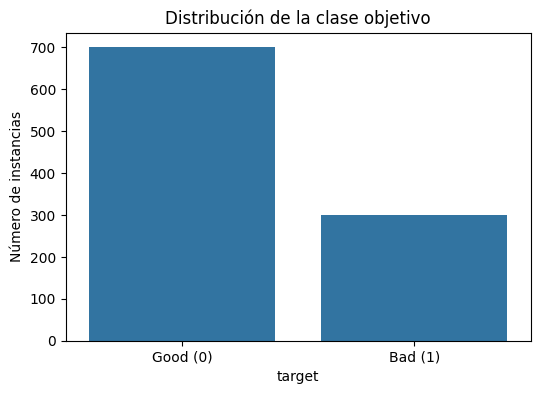

In [350]:
# Conteo y proporción
counts = df['target'].value_counts().sort_index()
props = df['target'].value_counts(normalize=True).sort_index()
print('Conteos:\n', counts)
print('\nProporciones:\n', props)

# Gráfico
plt.figure(figsize=(6,4))
sns.barplot(x=counts.index, y=counts.values)
plt.xticks([0,1], ['Good (0)', 'Bad (1)'])
plt.title('Distribución de la clase objetivo')
plt.ylabel('Número de instancias')
plt.show()

**Interpretación (negocio)**

* Conocer si existe desbalance. En el dataset clásico suele haber más buenos que malos. Un desbalance moderado afecta métricas como accuracy y obliga a priorizar métricas por clase (recall para malos si queremos reducir riesgo de aprobar a malos).

### 4. Valores faltantes y duplicados

In [351]:
# Valores faltantes
missing = df.isnull().sum()
missing[missing>0]

# Duplicados
dups = df.duplicated().sum()
print('Duplicados totales:', dups)

Duplicados totales: 0


**Reglas / acciones**

* Si missing.sum()==0: no se aplica imputación.

* Si hay valores NaN en num_cols: imputar con medianas (robusto) y crear columna indicador _missing para cada num_col con NaN (para traza y modelos lineales/árboles).

* Si hay duplicados: eliminar df = df.drop_duplicates() y documentar cuántas filas se eliminaron.

Justificación: imputar con la mediana evita sesgo por outliers; marcar faltantes preserva señal útil.

### 5. Análisis univariado y bivariado (gráficos sugeridos y código)

#### 5.1 Numéricos — histogramas y boxplots

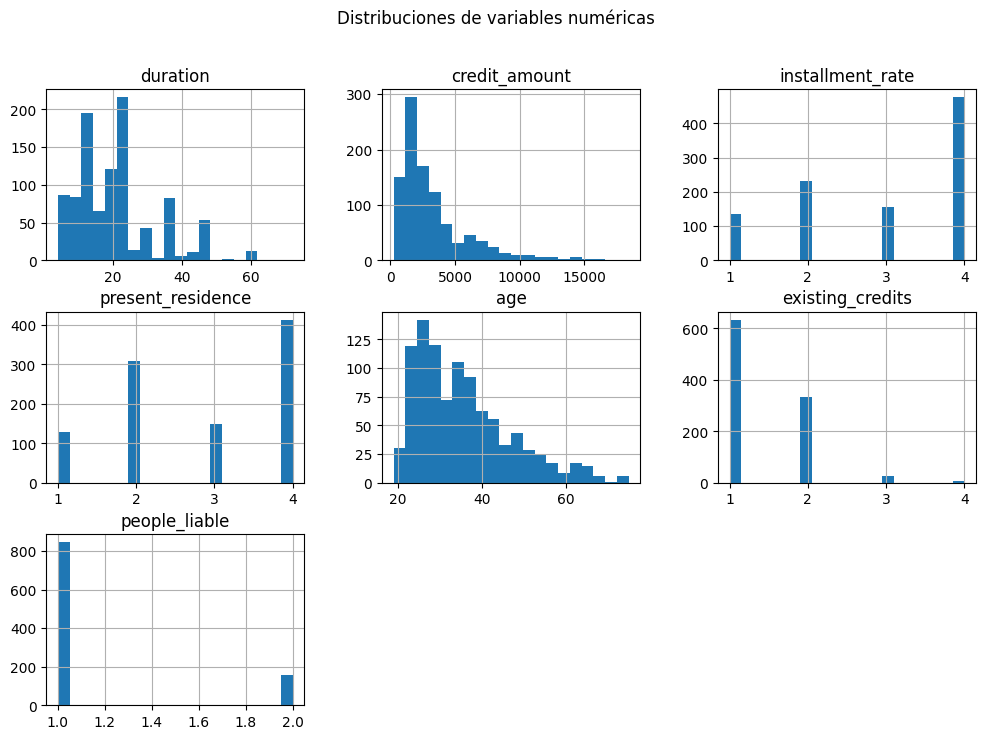

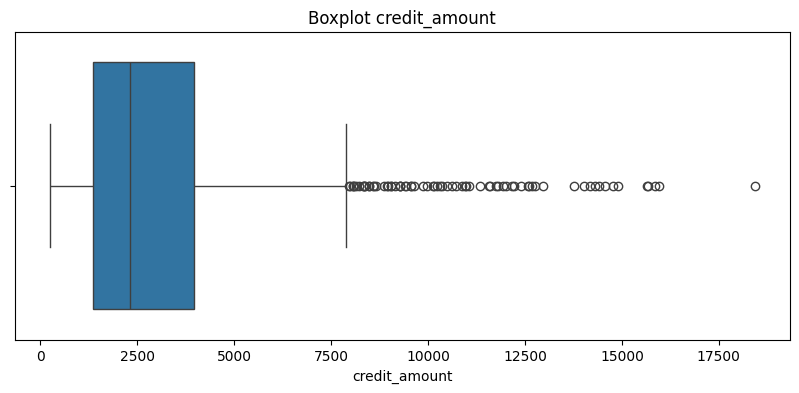

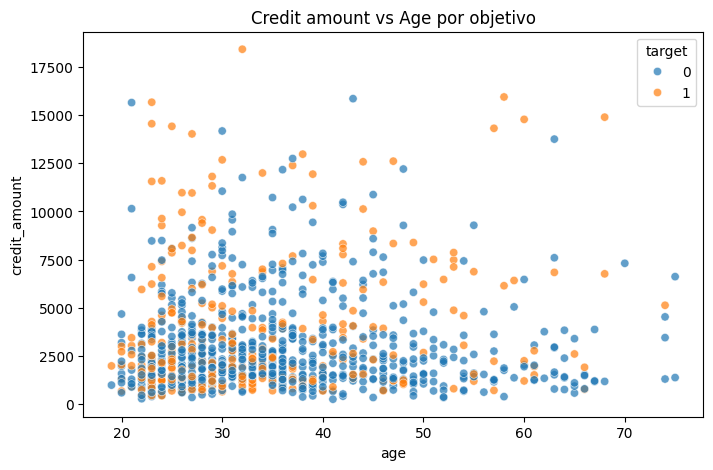

In [352]:
# Histogramas
df[num_cols].hist(bins=20, figsize=(12,8))
plt.suptitle('Distribuciones de variables numéricas')
plt.show()

# Boxplots para ver outliers (ej: credit_amount, age, duration)
plt.figure(figsize=(10,4))
sns.boxplot(x=df['credit_amount'])
plt.title('Boxplot credit_amount')
plt.show()

# Scatter: credit_amount vs age coloreado por target
plt.figure(figsize=(8,5))
sns.scatterplot(data=df, x='age', y='credit_amount', hue='target', alpha=0.7)
plt.title('Credit amount vs Age por objetivo')
plt.show()

#### 5.2 Categóricas — conteos y tasas por clase

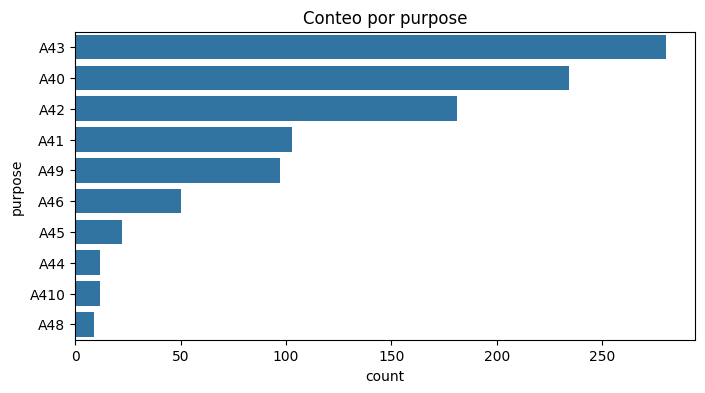

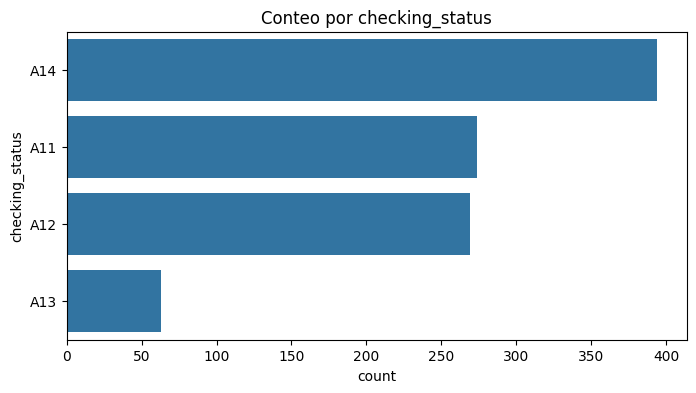

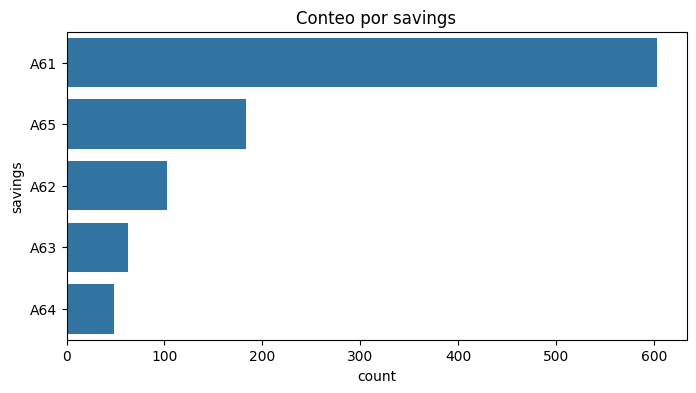

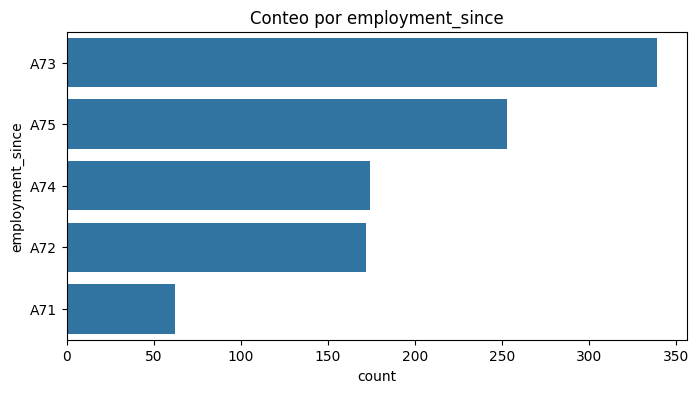

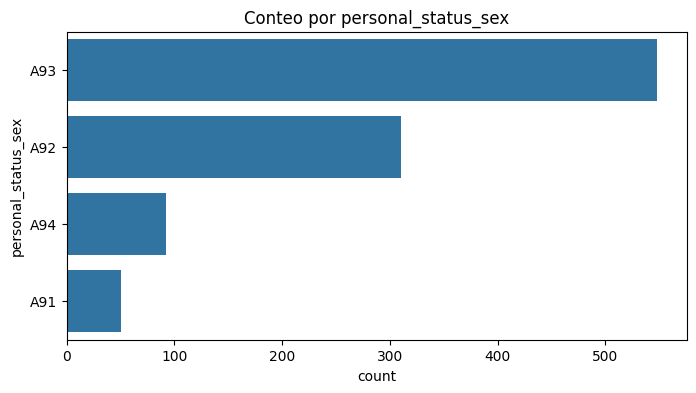

Tasa de default por purpose:
 purpose
A46     0.440000
A410    0.416667
A40     0.380342
A45     0.363636
A49     0.350515
A44     0.333333
A42     0.320442
A43     0.221429
A41     0.165049
A48     0.111111
Name: target, dtype: float64


In [353]:
cat_cols = [c for c in df.columns if df[c].dtype == 'object']

# Conteos de categorías para Atributos clave (purpose, checking_status, savings, employment_since, personal_status_sex)
for c in ['purpose','checking_status','savings','employment_since','personal_status_sex']:
    plt.figure(figsize=(8,4))
    sns.countplot(y=c, data=df, order=df[c].value_counts().index)
    plt.title(f'Conteo por {c}')
    plt.show()

# Tasa de default por categoría (ej: purpose)
default_rate = df.groupby('purpose')['target'].mean().sort_values(ascending=False)
print('Tasa de default por purpose:\n', default_rate)

**Cómo enlazar a hipótesis de negocio**

* Buscar categorías con tasa de default significativamente mayor. Por ejemplo, si "business" o "others" tienen mayor tasa de default, formular hipótesis: solicitudes para negocio pueden tener mayor riesgo (o coding issues).

* Variables numéricas: valores extremos de credit_amount pueden concentrar defaults.

### 6. Detección de outliers (reglas y código)

#### 6.1 Método IQR para variables clave

In [354]:
# Función para marcar outliers por IQR
def mark_outliers_iqr(series, k=1.5):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    low = q1 - k * iqr
    high = q3 + k * iqr
    return ((series < low) | (series > high))

outlier_flags = pd.DataFrame()
for c in ['credit_amount','duration','age']:
    outlier_flags[c + '_out'] = mark_outliers_iqr(df[c])

outlier_flags.sum()

,0
credit_amount_out,72
duration_out,70
age_out,23


#### 6.2 Reglas prácticas de tratamiento

* credit_amount: capear (winsorize) al percentil 99 o imputar por la mediana del bin similar (por ejemplo mismo purpose y age bucket). Razon: evitar que unos pocos préstamos extremadamente grandes dominen modelos lineales.

* duration: si valores extremos son realmente errores (ej: duración = 999) corregir o eliminar; si son válidos, convertir a buckets (corto/medio/largo) para modelos lineales.

* age: capear por abajo (edad mínima razonable) y marcar jóvenes (< 18) si existen.

Código ejemplo para winsorize:

In [355]:
from scipy.stats import mstats
# winsorize al 1% y 99%
df['credit_amount_w'] = mstats.winsorize(df['credit_amount'], limits=[0.01, 0.01])

Justificación de negocio: capping reduce overfitting por outliers y mejora interpretabilidad de coeficientes.

### 7. Transformaciones y encoding (preparación para modelado)

**Estrategia recomendada**

* Variables categóricas con pocas modalidades: One-Hot Encoding (ej: housing, telephone, foreign_worker)

* Variables categóricas ordinales (employment_since, savings buckets): mapear a enteros ordenados si el orden tiene sentido.

* Para modelos lineales: usar dummies y evitar multicolinealidad (drop_first=True)

* Para árboles/ensemble: Label Encoding o mantener códigos originales.

* Escalado: solo para regresión logística y redes (StandardScaler o RobustScaler para variables numéricas). No escalar para árboles.

In [356]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
# Ejemplo simple: one-hot para purpose
df_enc = pd.get_dummies(df, columns=['purpose','checking_status','savings','personal_status_sex','housing'], drop_first=True)

# Escalado para variables numéricas si usas modelos lineales o red
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
df_enc[num_cols] = scaler.fit_transform(df_enc[num_cols])

### 8. Reglas de limpieza aplicadas (documentadas)

1. Conversión de tipos: asegurar que columnas numéricas sean int/float.
    * Impacto: evita errores en modelos; permite estadísticas descriptivas correctas.
2. Mapeo de target a binario (0=Good, 1=Bad).
    * Impacto: simplifica evaluación y coincide con las métricas de riesgo (bad = evento positivo que queremos detectar).
3. Detección y eliminación de duplicados.
    * Regla: df = df.drop_duplicates().
    * Impacto: evita sobrecontar observaciones; si muchos duplicados, investigar origen.
4. Tratamiento de faltantes.
    * Regla: imputar numéricos con mediana y crear flag _is_missing por variable.
    * Impacto: mantiene robustez y preserva información que podría ser predictiva.
5. Outliers.
    * Regla: marcar outliers por IQR; winsorize al 1%/99% para credit_amount y capear extremos razonables.
    * Impacto: reduce influencia desproporcionada en coeficientes y en gradientes de redes; conserva la mayoría de datos.
6. Encoding y escalado según modelo (One-Hot para regresión, Label para árboles; escala para redes y regresión logística).
    * Impacto: prepara datos para que cada algoritmo funcione de forma óptima y que las interpretaciones (coeficientes) sean coherentes.

### 9. Hipótesis de negocio conectadas a EDA

* Hipótesis 1: solicitantes con credit_amount elevado y duration largo tienen mayor probabilidad de default. Acción: crear segmentos por quintiles y comparar tasas de default.

* Hipótesis 2: falta de savings o historial de crédito crítico (credit_history tipo A34) se asocia con mayor tasa de malos.

* Hipótesis 3: ciertas finalidades (purpose) muestran más riesgo (por ejemplo, "business" o "others").

Para comprobarlas: agrupar por esos bins/categorías y comparar target.mean(); añadir gráficas de barras con tasas de default.

## 2) Modelado con probabilidades calibradas

In [357]:
# Librerías para modelado y calibración
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, average_precision_score,
                             confusion_matrix, roc_curve, precision_recall_curve,
                             classification_report)
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy import stats

# Configuración
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
print("✓ Librerías importadas correctamente")

✓ Librerías importadas correctamente


In [358]:
# Asumiendo que ya tienes df_enc del EDA con limpieza aplicada
# Separar features (X) y target (y)

# Variables a excluir del modelado (target y cualquier ID)
target_col = 'target'
exclude_cols = [target_col]

# Crear X e y
X = df.drop(columns=exclude_cols)
y = df[target_col]

print(f"Shape de X: {X.shape}")
print(f"Shape de y: {y.shape}")
print(f"\nDistribución de clases en y:")
print(y.value_counts())
print(f"\nProporción de clases:")
print(y.value_counts(normalize=True))

Shape de X: (1000, 21)
Shape de y: (1000,)

Distribución de clases en y:
target
0    700
1    300
Name: count, dtype: int64

Proporción de clases:
target
0    0.7
1    0.3
Name: proportion, dtype: float64


In [359]:
# DIAGNÓSTICO: Verificar qué columnas tienen problemas
print("="*60)
print("DIAGNÓSTICO DE TIPOS DE DATOS")
print("="*60)

print("\nTipos de datos actuales:")
print(X.dtypes.value_counts())

print("\n" + "="*60)
print("COLUMNAS CON TIPO 'object' (categóricas sin codificar):")
print("="*60)
cat_cols = X.select_dtypes(include=['object']).columns.tolist()
print(f"Total: {len(cat_cols)}")
print(cat_cols)

if len(cat_cols) > 0:
    print("\nEjemplos de valores en estas columnas:")
    for col in cat_cols[:5]:  # Mostrar primeras 5
        print(f"\n{col}:")
        print(X[col].value_counts().head())
else:
    print("\n✓ No hay columnas categóricas sin codificar")

DIAGNÓSTICO DE TIPOS DE DATOS

Tipos de datos actuales:
object    13
int64      8
Name: count, dtype: int64

COLUMNAS CON TIPO 'object' (categóricas sin codificar):
Total: 13
['checking_status', 'credit_history', 'purpose', 'savings', 'employment_since', 'personal_status_sex', 'other_debtors', 'property', 'other_installment_plans', 'housing', 'job', 'telephone', 'foreign_worker']

Ejemplos de valores en estas columnas:

checking_status:
checking_status
A14    394
A11    274
A12    269
A13     63
Name: count, dtype: int64

credit_history:
credit_history
A32    530
A34    293
A33     88
A31     49
A30     40
Name: count, dtype: int64

purpose:
purpose
A43    280
A40    234
A42    181
A41    103
A49     97
Name: count, dtype: int64

savings:
savings
A61    603
A65    183
A62    103
A63     63
A64     48
Name: count, dtype: int64

employment_since:
employment_since
A73    339
A75    253
A74    174
A72    172
A71     62
Name: count, dtype: int64


In [360]:
# IMPORTANTE: Hacer split ANTES de encoding para evitar data leakage
# Split estratificado 70/30

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=RANDOM_STATE,
    stratify=y
)

print("="*60)
print("SPLIT DE DATOS")
print("="*60)
print(f"Tamaño train: {X_train.shape[0]} ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Tamaño test: {X_test.shape[0]} ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"\nDistribución en train:")
print(y_train.value_counts())
print(f"\nDistribución en test:")
print(y_test.value_counts())
print(f"\nProporción Bad en train: {y_train.mean():.3f}")
print(f"Proporción Bad en test: {y_test.mean():.3f}")

SPLIT DE DATOS
Tamaño train: 700 (70.0%)
Tamaño test: 300 (30.0%)

Distribución en train:
target
0    490
1    210
Name: count, dtype: int64

Distribución en test:
target
0    210
1     90
Name: count, dtype: int64

Proporción Bad en train: 0.300
Proporción Bad en test: 0.300


In [361]:
# SOLUCIÓN: Aplicar encoding a todas las variables categóricas

# Paso 1: Identificar columnas categóricas
categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()

print("="*60)
print("APLICANDO ONE-HOT ENCODING")
print("="*60)
print(f"Columnas categóricas encontradas: {len(categorical_cols)}")

if len(categorical_cols) > 0:
    print("\nColumnas a codificar:")
    for i, col in enumerate(categorical_cols, 1):
        n_cats = X_train[col].nunique()
        print(f"  {i}. {col}: {n_cats} categorías")

    # Encoding en train
    X_train_encoded = pd.get_dummies(
        X_train,
        columns=categorical_cols,
        drop_first=True,  # Evitar multicolinealidad
        prefix=categorical_cols
    )

    # Encoding en test (mismo esquema)
    X_test_encoded = pd.get_dummies(
        X_test,
        columns=categorical_cols,
        drop_first=True,
        prefix=categorical_cols
    )

    # Paso 3: Alinear columnas (test debe tener mismas columnas que train)
    # Agregar columnas faltantes en test con valor 0
    missing_cols = set(X_train_encoded.columns) - set(X_test_encoded.columns)
    for col in missing_cols:
        X_test_encoded[col] = 0

    # Eliminar columnas extra en test que no están en train
    extra_cols = set(X_test_encoded.columns) - set(X_train_encoded.columns)
    X_test_encoded = X_test_encoded.drop(columns=list(extra_cols))

    # Reordenar columnas para que coincidan
    X_test_encoded = X_test_encoded[X_train_encoded.columns]

    # Actualizar X_train y X_test
    X_train = X_train_encoded
    X_test = X_test_encoded

    print(f"\n✓ Encoding completado")
    print(f"  Shape original: {len(categorical_cols)} columnas categóricas")
    print(f"  Shape final X_train: {X_train.shape}")
    print(f"  Shape final X_test: {X_test.shape}")
    print(f"  Total features: {X_train.shape[1]}")

else:
    print("\n✓ No hay columnas categóricas, dataset ya está codificado")

# Verificación final
print("\n" + "="*60)
print("VERIFICACIÓN FINAL")
print("="*60)
print("Tipos de datos restantes:")
print(X_train.dtypes.value_counts())

# Verificar que no hay más 'object'
if 'object' in X_train.dtypes.values:
    print("\n⚠️ ADVERTENCIA: Aún quedan columnas tipo 'object'")
    print(X_train.select_dtypes(include=['object']).columns.tolist())
else:
    print("\n✓ Todos los datos son numéricos. Listo para modelar.")

APLICANDO ONE-HOT ENCODING
Columnas categóricas encontradas: 13

Columnas a codificar:
  1. checking_status: 4 categorías
  2. credit_history: 5 categorías
  3. purpose: 10 categorías
  4. savings: 5 categorías
  5. employment_since: 5 categorías
  6. personal_status_sex: 4 categorías
  7. other_debtors: 3 categorías
  8. property: 4 categorías
  9. other_installment_plans: 3 categorías
  10. housing: 3 categorías
  11. job: 4 categorías
  12. telephone: 2 categorías
  13. foreign_worker: 2 categorías

✓ Encoding completado
  Shape original: 13 columnas categóricas
  Shape final X_train: (700, 49)
  Shape final X_test: (300, 49)
  Total features: 49

VERIFICACIÓN FINAL
Tipos de datos restantes:
bool     41
int64     8
Name: count, dtype: int64

✓ Todos los datos son numéricos. Listo para modelar.


In [362]:
# Escalado SOLO para modelos que lo requieren (regresión y redes)
# NO escalar para árboles y Random Forest

print("="*60)
print("ESCALADO DE DATOS")
print("="*60)

# Crear copia para modelos lineales/redes
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

# Ajustar scaler solo con train
scaler = StandardScaler()
scaler.fit(X_train_scaled)

# Transformar ambos conjuntos
X_train_scaled = pd.DataFrame(
    scaler.transform(X_train_scaled),
    columns=X_train.columns,
    index=X_train.index
)

X_test_scaled = pd.DataFrame(
    scaler.transform(X_test_scaled),
    columns=X_test.columns,
    index=X_test.index
)

print("✓ Escalado completado")
print(f"  Media de X_train_scaled: {X_train_scaled.mean().mean():.6f}")
print(f"  Std de X_train_scaled: {X_train_scaled.std().mean():.6f}")
print(f"\nNOTA:")
print("  • X_train_scaled / X_test_scaled → Para Regresión Logística y Red Neuronal")
print("  • X_train / X_test → Para Árboles y Random Forest")

ESCALADO DE DATOS
✓ Escalado completado
  Media de X_train_scaled: -0.000000
  Std de X_train_scaled: 1.000715

NOTA:
  • X_train_scaled / X_test_scaled → Para Regresión Logística y Red Neuronal
  • X_train / X_test → Para Árboles y Random Forest


In [363]:
def calibrate_model(base_model, X_train, y_train, method='isotonic', cv=5):
    """
    Calibra un modelo usando CalibratedClassifierCV.

    Parámetros:
    - base_model: modelo base ya entrenado o sin entrenar
    - X_train: features de entrenamiento
    - y_train: target de entrenamiento
    - method: 'sigmoid' (Platt) o 'isotonic'
    - cv: número de folds para calibración

    Retorna: modelo calibrado
    """
    calibrated = CalibratedClassifierCV(
        base_model,
        method=method,
        cv=cv
    )
    calibrated.fit(X_train, y_train)
    return calibrated

print("="*60)
print("MÉTODOS DE CALIBRACIÓN")
print("="*60)
print("• 'sigmoid' (Platt): Asume relación sigmoidal")
print("  - Ventajas: Funciona bien con pocos datos")
print("  - Desventajas: Asume forma paramétrica")
print("\n• 'isotonic': Regresión isotónica no paramétrica")
print("  - Ventajas: Más flexible, mejor calibración con suficientes datos")
print("  - Desventajas: Requiere más datos (n > 500)")
print(f"\nNuestra elección: 'isotonic' (tenemos n={len(X_train)})")

MÉTODOS DE CALIBRACIÓN
• 'sigmoid' (Platt): Asume relación sigmoidal
  - Ventajas: Funciona bien con pocos datos
  - Desventajas: Asume forma paramétrica

• 'isotonic': Regresión isotónica no paramétrica
  - Ventajas: Más flexible, mejor calibración con suficientes datos
  - Desventajas: Requiere más datos (n > 500)

Nuestra elección: 'isotonic' (tenemos n=700)


In [364]:
# Estructura para guardar todo
models_dict = {
    'Logistic Regression': {},
    'Decision Tree': {},
    'Random Forest': {},
    'Neural Network': {}
}

print("="*60)
print("ESTRUCTURA DE ALMACENAMIENTO")
print("="*60)
print("Para cada modelo guardaremos:")
print("  • 'base': Modelo sin calibrar")
print("  • 'calibrated': Modelo calibrado")
print("  • 'y_pred_proba': Probabilidades en test")
print("  • 'y_pred': Predicciones binarias (umbral 0.5)")
print("  • 'threshold': Umbral óptimo encontrado")
print("  • 'metrics': Métricas de evaluación")
print("  • Información específica del modelo (coefs, importances, etc.)")

ESTRUCTURA DE ALMACENAMIENTO
Para cada modelo guardaremos:
  • 'base': Modelo sin calibrar
  • 'calibrated': Modelo calibrado
  • 'y_pred_proba': Probabilidades en test
  • 'y_pred': Predicciones binarias (umbral 0.5)
  • 'threshold': Umbral óptimo encontrado
  • 'metrics': Métricas de evaluación
  • Información específica del modelo (coefs, importances, etc.)


In [365]:
print("\n" + "="*60)
print("MODELO 1: REGRESIÓN LOGÍSTICA")
print("="*60)

# Entrenar modelo base con datos ESCALADOS
lr_base = LogisticRegression(
    max_iter=1000,
    random_state=RANDOM_STATE,
    class_weight='balanced',  # Manejar desbalance
    solver='lbfgs',
    penalty='l2',
    C=1.0  # Parámetro de regularización (inverso de fuerza)
)

lr_base.fit(X_train_scaled, y_train)

# Guardar en diccionario
models_dict['Logistic Regression']['base'] = lr_base

# Predicciones base (sin calibrar)
y_pred_proba_base = lr_base.predict_proba(X_test_scaled)[:, 1]
y_pred_base = (y_pred_proba_base >= 0.5).astype(int)

print(f"✓ Modelo entrenado")
print(f"  Número de features: {X_train_scaled.shape[1]}")
print(f"  Número de iteraciones: {lr_base.n_iter_[0]}")
print(f"\nMétricas base (sin calibrar, umbral=0.5):")
print(f"  Accuracy: {accuracy_score(y_test, y_pred_base):.4f}")
print(f"  Precision: {precision_score(y_test, y_pred_base):.4f}")
print(f"  Recall: {recall_score(y_test, y_pred_base):.4f}")
print(f"  F1-Score: {f1_score(y_test, y_pred_base):.4f}")
print(f"  ROC-AUC: {roc_auc_score(y_test, y_pred_proba_base):.4f}")


MODELO 1: REGRESIÓN LOGÍSTICA
✓ Modelo entrenado
  Número de features: 49
  Número de iteraciones: 25

Métricas base (sin calibrar, umbral=0.5):
  Accuracy: 0.7333
  Precision: 0.5391
  Recall: 0.7667
  F1-Score: 0.6330
  ROC-AUC: 0.7989


In [366]:
# Calibrar con método isotonic
print("\n" + "-"*60)
print("CALIBRANDO MODELO...")
print("-"*60)

lr_calibrated = calibrate_model(
    lr_base,
    X_train_scaled,
    y_train,
    method='isotonic',
    cv=5
)

# Predicciones calibradas
y_pred_proba_cal = lr_calibrated.predict_proba(X_test_scaled)[:, 1]
y_pred_cal = (y_pred_proba_cal >= 0.5).astype(int)

# Guardar
models_dict['Logistic Regression']['calibrated'] = lr_calibrated
models_dict['Logistic Regression']['y_pred_proba'] = y_pred_proba_cal
models_dict['Logistic Regression']['y_pred'] = y_pred_cal

print(f"✓ Calibración completada")
print(f"\nMétricas calibradas (umbral=0.5):")
print(f"  Accuracy: {accuracy_score(y_test, y_pred_cal):.4f}")
print(f"  Precision: {precision_score(y_test, y_pred_cal):.4f}")
print(f"  Recall: {recall_score(y_test, y_pred_cal):.4f}")
print(f"  F1-Score: {f1_score(y_test, y_pred_cal):.4f}")
print(f"  ROC-AUC: {roc_auc_score(y_test, y_pred_proba_cal):.4f}")

# Comparación
print(f"\nCambio en probabilidades:")
print(f"  Correlación base vs calibrada: {np.corrcoef(y_pred_proba_base, y_pred_proba_cal)[0,1]:.4f}")
print(f"  Diferencia promedio: {np.abs(y_pred_proba_base - y_pred_proba_cal).mean():.4f}")


------------------------------------------------------------
CALIBRANDO MODELO...
------------------------------------------------------------
✓ Calibración completada

Métricas calibradas (umbral=0.5):
  Accuracy: 0.7667
  Precision: 0.7273
  Recall: 0.3556
  F1-Score: 0.4776
  ROC-AUC: 0.7964

Cambio en probabilidades:
  Correlación base vs calibrada: 0.9754
  Diferencia promedio: 0.1443


In [367]:
# Extraer coeficientes del modelo base
coef_df = pd.DataFrame({
    'Feature': X_train_scaled.columns,
    'Coefficient': lr_base.coef_[0],
    'Abs_Coefficient': np.abs(lr_base.coef_[0])
}).sort_values('Abs_Coefficient', ascending=False)

# Calcular Odds Ratios
coef_df['Odds_Ratio'] = np.exp(coef_df['Coefficient'])

# Agregar interpretación
coef_df['Interpretation'] = coef_df['Coefficient'].apply(
    lambda x: 'Aumenta riesgo' if x > 0 else 'Reduce riesgo'
)

# Mostrar top 20
print("\n" + "="*60)
print("COEFICIENTES Y ODDS RATIOS (Top 20)")
print("="*60)
print(coef_df.head(20).to_string(index=False))

# Estadísticas
print("\n" + "="*60)
print("ESTADÍSTICAS DE COEFICIENTES")
print("="*60)
print(f"Coeficientes positivos (aumentan riesgo): {(coef_df['Coefficient'] > 0).sum()}")
print(f"Coeficientes negativos (reducen riesgo): {(coef_df['Coefficient'] < 0).sum()}")
print(f"Coeficiente máximo: {coef_df['Coefficient'].max():.4f} ({coef_df.iloc[0]['Feature']})")
print(f"Coeficiente mínimo: {coef_df['Coefficient'].min():.4f}")

# Interpretación de negocio
print("\n" + "="*60)
print("INTERPRETACIÓN PARA NEGOCIO")
print("="*60)
top_risk = coef_df.head(3)
print("\nTop 3 factores que AUMENTAN riesgo de default:")
for i, row in enumerate(top_risk[top_risk['Coefficient'] > 0].iterrows(), 1):
    feat, data = row
    if i <= 3:
        print(f"{i}. {data['Feature']}")
        print(f"   OR = {data['Odds_Ratio']:.3f} (aumenta odds en {(data['Odds_Ratio']-1)*100:.1f}%)")

top_protect = coef_df[coef_df['Coefficient'] < 0].head(3)
print("\nTop 3 factores que REDUCEN riesgo de default:")
for i, row in enumerate(top_protect.iterrows(), 1):
    feat, data = row
    print(f"{i}. {data['Feature']}")
    print(f"   OR = {data['Odds_Ratio']:.3f} (reduce odds en {(1-data['Odds_Ratio'])*100:.1f}%)")

# Guardar
models_dict['Logistic Regression']['coefficients'] = coef_df


COEFICIENTES Y ODDS RATIOS (Top 20)
                     Feature  Coefficient  Abs_Coefficient  Odds_Ratio Interpretation
         checking_status_A14    -0.816671         0.816671    0.441900  Reduce riesgo
          credit_history_A34    -0.561905         0.561905    0.570122  Reduce riesgo
        employment_since_A74    -0.483053         0.483053    0.616897  Reduce riesgo
               property_A124     0.413104         0.413104    1.511502 Aumenta riesgo
                 savings_A65    -0.398987         0.398987    0.671000  Reduce riesgo
other_installment_plans_A143    -0.386710         0.386710    0.679288  Reduce riesgo
     personal_status_sex_A93    -0.358336         0.358336    0.698838  Reduce riesgo
            installment_rate     0.339793         0.339793    1.404657 Aumenta riesgo
                    duration     0.334153         0.334153    1.396756 Aumenta riesgo
         foreign_worker_A202    -0.331527         0.331527    0.717827  Reduce riesgo
                 

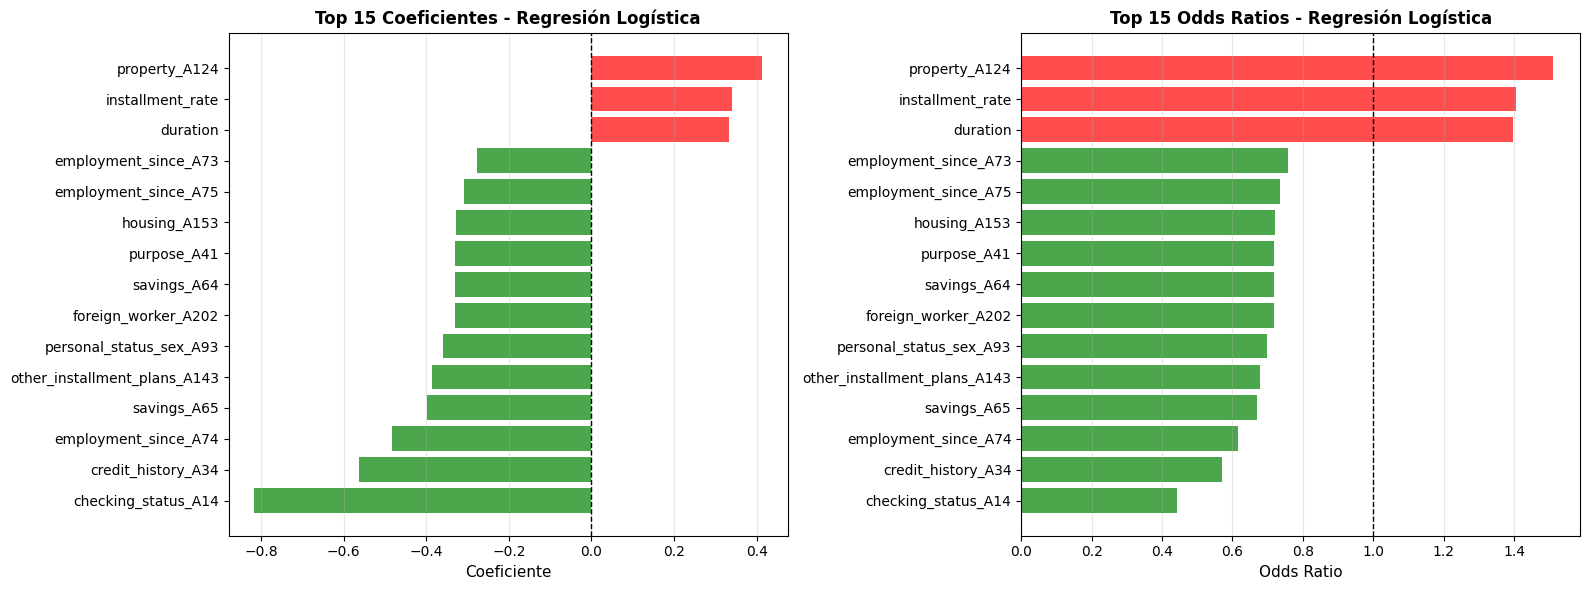

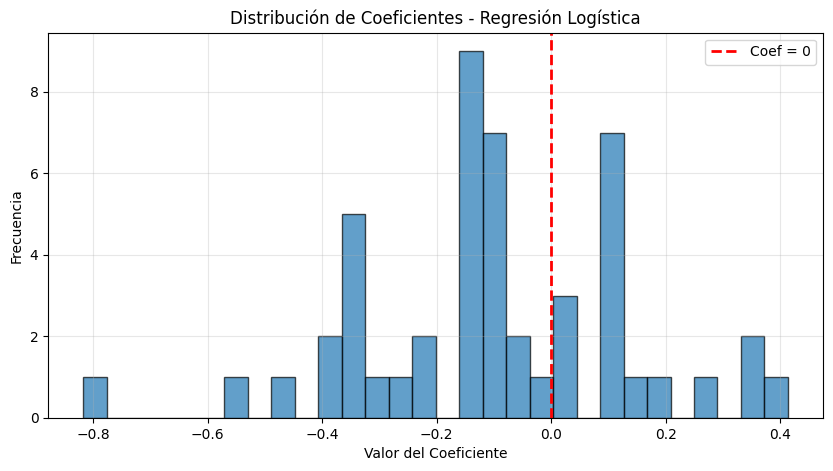

In [368]:
# Gráfico de coeficientes top 15
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Coeficientes
top_coefs = coef_df.head(15).sort_values('Coefficient')
colors = ['red' if x > 0 else 'green' for x in top_coefs['Coefficient']]
ax1.barh(top_coefs['Feature'], top_coefs['Coefficient'], color=colors, alpha=0.7)
ax1.axvline(x=0, color='black', linestyle='--', linewidth=1)
ax1.set_xlabel('Coeficiente', fontsize=11)
ax1.set_title('Top 15 Coeficientes - Regresión Logística', fontsize=12, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

# Odds Ratios
top_or = coef_df.head(15).sort_values('Odds_Ratio')
colors_or = ['red' if x > 1 else 'green' for x in top_or['Odds_Ratio']]
ax2.barh(top_or['Feature'], top_or['Odds_Ratio'], color=colors_or, alpha=0.7)
ax2.axvline(x=1, color='black', linestyle='--', linewidth=1)
ax2.set_xlabel('Odds Ratio', fontsize=11)
ax2.set_title('Top 15 Odds Ratios - Regresión Logística', fontsize=12, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# Distribución de coeficientes
plt.figure(figsize=(10, 5))
plt.hist(coef_df['Coefficient'], bins=30, edgecolor='black', alpha=0.7)
plt.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Coef = 0')
plt.xlabel('Valor del Coeficiente')
plt.ylabel('Frecuencia')
plt.title('Distribución de Coeficientes - Regresión Logística')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [369]:
print("\n" + "="*60)
print("MODELO 2: ÁRBOL DE DECISIÓN")
print("="*60)

# Entrenar árbol con profundidad limitada para interpretabilidad
# USAR DATOS SIN ESCALAR
dt_base = DecisionTreeClassifier(
    max_depth=5,  # Limitar profundidad para reglas interpretables
    min_samples_split=50,
    min_samples_leaf=20,
    random_state=RANDOM_STATE,
    class_weight='balanced',
    criterion='gini'  # Alternativa: 'entropy'
)

dt_base.fit(X_train, y_train)

# Guardar
models_dict['Decision Tree']['base'] = dt_base

# Predicciones base
y_pred_proba_base = dt_base.predict_proba(X_test)[:, 1]
y_pred_base = (y_pred_proba_base >= 0.5).astype(int)

print(f"✓ Modelo entrenado")
print(f"  Profundidad del árbol: {dt_base.get_depth()}")
print(f"  Número de hojas: {dt_base.get_n_leaves()}")
print(f"  Número de nodos: {dt_base.tree_.node_count}")
print(f"\nMétricas base (sin calibrar, umbral=0.5):")
print(f"  Accuracy: {accuracy_score(y_test, y_pred_base):.4f}")
print(f"  Precision: {precision_score(y_test, y_pred_base):.4f}")
print(f"  Recall: {recall_score(y_test, y_pred_base):.4f}")
print(f"  F1-Score: {f1_score(y_test, y_pred_base):.4f}")
print(f"  ROC-AUC: {roc_auc_score(y_test, y_pred_proba_base):.4f}")


MODELO 2: ÁRBOL DE DECISIÓN
✓ Modelo entrenado
  Profundidad del árbol: 5
  Número de hojas: 13
  Número de nodos: 25

Métricas base (sin calibrar, umbral=0.5):
  Accuracy: 0.6200
  Precision: 0.4241
  Recall: 0.7444
  F1-Score: 0.5403
  ROC-AUC: 0.7265


In [370]:
# Calibrar árbol
print("\n" + "-"*60)
print("CALIBRANDO MODELO...")
print("-"*60)

dt_calibrated = calibrate_model(
    dt_base,
    X_train,
    y_train,
    method='isotonic',
    cv=5
)

# Predicciones calibradas
y_pred_proba_cal = dt_calibrated.predict_proba(X_test)[:, 1]
y_pred_cal = (y_pred_proba_cal >= 0.5).astype(int)

# Guardar
models_dict['Decision Tree']['calibrated'] = dt_calibrated
models_dict['Decision Tree']['y_pred_proba'] = y_pred_proba_cal
models_dict['Decision Tree']['y_pred'] = y_pred_cal

print(f"✓ Calibración completada")
print(f"\nMétricas calibradas (umbral=0.5):")
print(f"  Accuracy: {accuracy_score(y_test, y_pred_cal):.4f}")
print(f"  Precision: {precision_score(y_test, y_pred_cal):.4f}")
print(f"  Recall: {recall_score(y_test, y_pred_cal):.4f}")
print(f"  F1-Score: {f1_score(y_test, y_pred_cal):.4f}")
print(f"  ROC-AUC: {roc_auc_score(y_test, y_pred_proba_cal):.4f}")

# Comparación
print(f"\nCambio en probabilidades:")
print(f"  Correlación base vs calibrada: {np.corrcoef(y_pred_proba_base, y_pred_proba_cal)[0,1]:.4f}")
print(f"  Diferencia promedio: {np.abs(y_pred_proba_base - y_pred_proba_cal).mean():.4f}")


------------------------------------------------------------
CALIBRANDO MODELO...
------------------------------------------------------------
✓ Calibración completada

Métricas calibradas (umbral=0.5):
  Accuracy: 0.7000
  Precision: 0.5000
  Recall: 0.1000
  F1-Score: 0.1667
  ROC-AUC: 0.7444

Cambio en probabilidades:
  Correlación base vs calibrada: 0.9037
  Diferencia promedio: 0.1697


In [371]:
# Extraer reglas en formato texto
print("\n" + "="*60)
print("REGLAS DEL ÁRBOL (formato texto)")
print("="*60)

tree_rules = export_text(dt_base, feature_names=list(X_train.columns), max_depth=4)
print(tree_rules[:3000])  # Mostrar primeras reglas

# Guardar reglas completas
models_dict['Decision Tree']['rules_text'] = tree_rules

print("\n[...reglas adicionales omitidas por espacio...]")
print(f"\nTotal de caracteres en reglas: {len(tree_rules)}")


REGLAS DEL ÁRBOL (formato texto)
|--- checking_status_A14 <= 0.50
|   |--- duration <= 11.50
|   |   |--- age <= 35.50
|   |   |   |--- class: 1
|   |   |--- age >  35.50
|   |   |   |--- class: 0
|   |--- duration >  11.50
|   |   |--- savings_A65 <= 0.50
|   |   |   |--- duration <= 22.50
|   |   |   |   |--- credit_amount <= 954.50
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- credit_amount >  954.50
|   |   |   |   |   |--- class: 1
|   |   |   |--- duration >  22.50
|   |   |   |   |--- installment_rate <= 2.50
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- installment_rate >  2.50
|   |   |   |   |   |--- class: 1
|   |   |--- savings_A65 >  0.50
|   |   |   |--- class: 0
|--- checking_status_A14 >  0.50
|   |--- other_installment_plans_A143 <= 0.50
|   |   |--- class: 1
|   |--- other_installment_plans_A143 >  0.50
|   |   |--- credit_history_A33 <= 0.50
|   |   |   |--- personal_status_sex_A92 <= 0.50
|   |   |   |   |--- property_A122 <= 0.50
|   |   |   |   

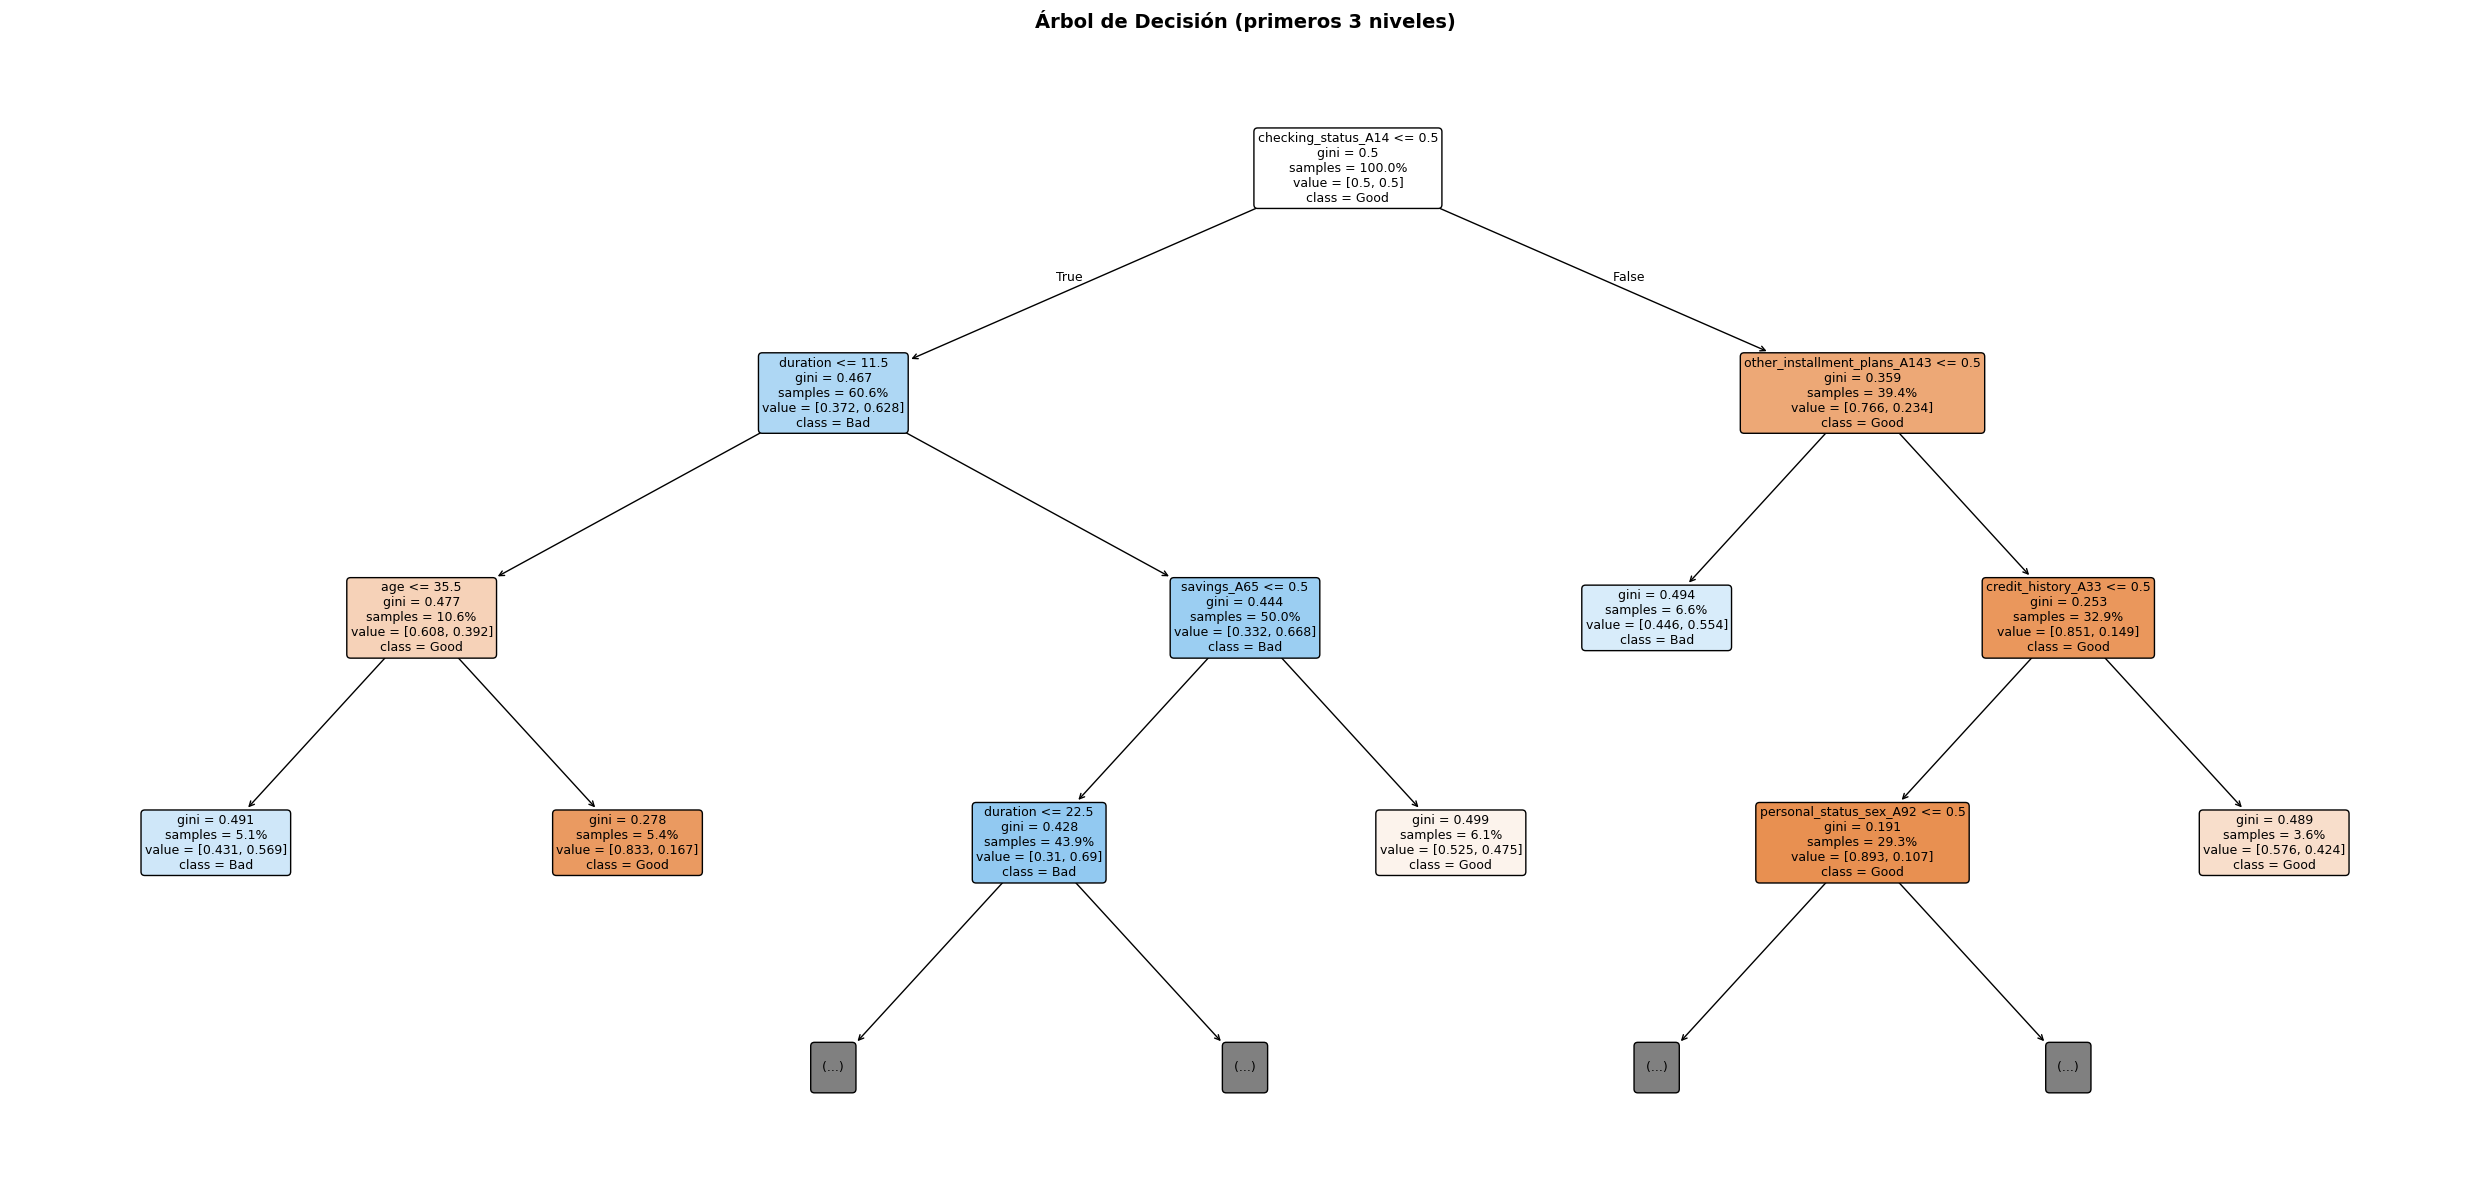

Interpretación del gráfico:
• Color naranja: Mayoría clase Bad (alto riesgo)
• Color azul: Mayoría clase Good (bajo riesgo)
• Intensidad del color: Pureza del nodo
• Valores en nodos: [samples de Good, samples de Bad]


In [372]:
# Visualizar árbol (solo primeros niveles para legibilidad)
plt.figure(figsize=(25, 12))
plot_tree(
    dt_base,
    feature_names=X_train.columns,
    class_names=['Good', 'Bad'],
    filled=True,
    rounded=True,
    max_depth=3,  # Mostrar solo primeros 3 niveles
    fontsize=9,
    proportion=True  # Mostrar proporciones en vez de conteos
)
plt.title('Árbol de Decisión (primeros 3 niveles)', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("Interpretación del gráfico:")
print("• Color naranja: Mayoría clase Bad (alto riesgo)")
print("• Color azul: Mayoría clase Good (bajo riesgo)")
print("• Intensidad del color: Pureza del nodo")
print("• Valores en nodos: [samples de Good, samples de Bad]")


IMPORTANCIA DE FEATURES - ÁRBOL (Top 20)
                     Feature  Importance
         checking_status_A14    0.487812
                    duration    0.134745
other_installment_plans_A143    0.128047
                         age    0.072230
               credit_amount    0.044275
          credit_history_A33    0.042255
                 savings_A65    0.036003
     personal_status_sex_A92    0.026237
            installment_rate    0.023980
               property_A122    0.004415
             credit_amount_w    0.000000
          credit_history_A31    0.000000
         checking_status_A13    0.000000
         checking_status_A12    0.000000
               people_liable    0.000000
            existing_credits    0.000000
           present_residence    0.000000
                purpose_A410    0.000000
                 purpose_A41    0.000000
          credit_history_A34    0.000000

Total features con importancia > 0: 10
Suma de importancias: 1.0000


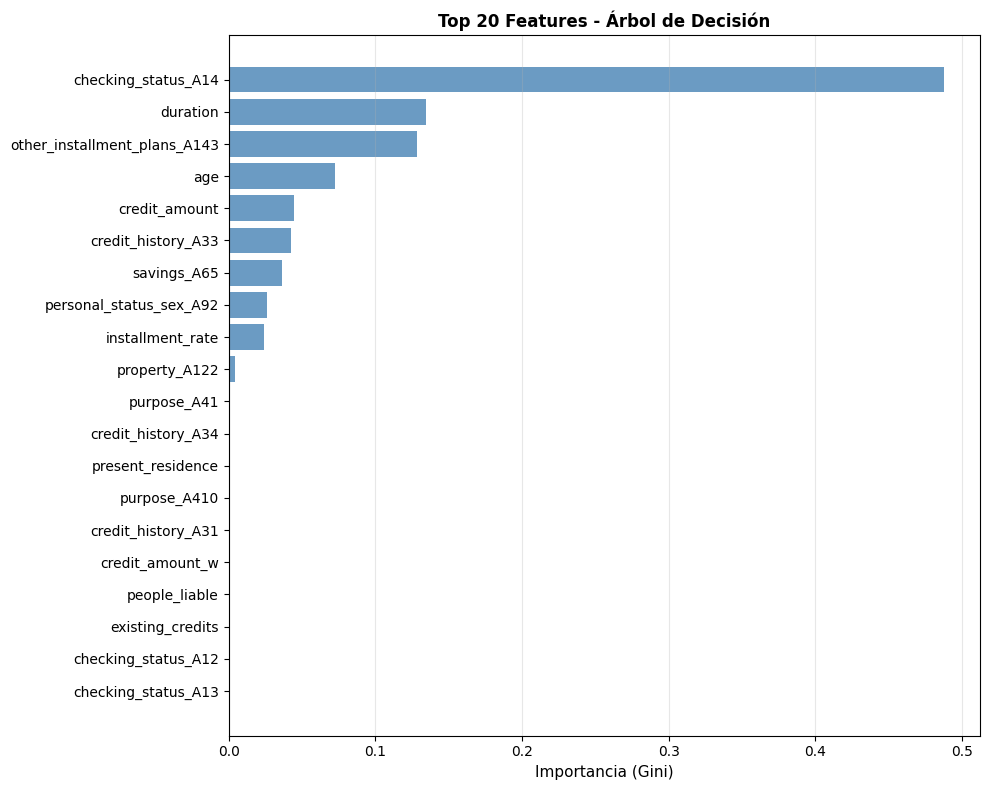

In [373]:
# Importancia de features
feature_importance_dt = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': dt_base.feature_importances_
}).sort_values('Importance', ascending=False)

print("\n" + "="*60)
print("IMPORTANCIA DE FEATURES - ÁRBOL (Top 20)")
print("="*60)
print(feature_importance_dt.head(20).to_string(index=False))

# Estadísticas
print(f"\nTotal features con importancia > 0: {(feature_importance_dt['Importance'] > 0).sum()}")
print(f"Suma de importancias: {feature_importance_dt['Importance'].sum():.4f}")

# Gráfico
plt.figure(figsize=(10, 8))
top_20 = feature_importance_dt.head(20).sort_values('Importance')
plt.barh(top_20['Feature'], top_20['Importance'], color='steelblue', alpha=0.8)
plt.xlabel('Importancia (Gini)', fontsize=11)
plt.title('Top 20 Features - Árbol de Decisión', fontsize=12, fontweight='bold')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Guardar
models_dict['Decision Tree']['feature_importance'] = feature_importance_dt

In [374]:
# Función para extraer caminos del árbol
from sklearn.tree import _tree

def extract_rules(tree, feature_names):
    """Extrae reglas del árbol en formato legible"""
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    paths = []

    def recurse(node, path, value):
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]

            # Rama izquierda (<=)
            p_left = path + [(name, '<=', threshold)]
            recurse(tree_.children_left[node], p_left, value)

            # Rama derecha (>)
            p_right = path + [(name, '>', threshold)]
            recurse(tree_.children_right[node], p_right, value)
        else:
            # Hoja: guardar regla y proporción de clase
            class_counts = tree_.value[node][0]
            total = sum(class_counts)
            prob_bad = class_counts[1] / total if total > 0 else 0
            n_samples = int(total)
            paths.append((path, prob_bad, n_samples))

    recurse(0, [], tree_.value[0])
    return paths

# Extraer reglas
rules = extract_rules(dt_base, X_train.columns)

# Filtrar reglas de alto riesgo (prob > 0.6 de ser Bad)
high_risk_rules = [(r, p, n) for r, p, n in rules if p > 0.6 and n >= 10]
high_risk_rules = sorted(high_risk_rules, key=lambda x: x[1], reverse=True)

print("\n" + "="*60)
print(f"REGLAS DE ALTO RIESGO (prob(Bad) > 0.6, n >= 10)")
print("="*60)
print(f"Total reglas de alto riesgo encontradas: {len(high_risk_rules)}")

for i, (rule, prob, n) in enumerate(high_risk_rules[:5], 1):
    print(f"\n{'='*50}")
    print(f"REGLA {i}: Riesgo={prob:.1%}, Casos={n}")
    print(f"{'='*50}")
    print("Condiciones:")
    for feat, op, thr in rule:
        print(f"  └─ {feat} {op} {thr:.3f}")
    print(f"\nInterpretación: {prob*100:.1f}% de los casos que cumplen")
    print(f"                estas condiciones son Bad (n={n} casos)")

# Guardar top 3
models_dict['Decision Tree']['high_risk_rules'] = high_risk_rules[:3]

# Reglas de bajo riesgo (opcional)
low_risk_rules = [(r, p, n) for r, p, n in rules if p < 0.3 and n >= 10]
low_risk_rules = sorted(low_risk_rules, key=lambda x: x[0])

print("\n" + "="*60)
print(f"REGLAS DE BAJO RIESGO (prob(Bad) < 0.3, n >= 10)")
print("="*60)
print(f"Total reglas de bajo riesgo encontradas: {len(low_risk_rules)}")

for i, (rule, prob, n) in enumerate(low_risk_rules[:3], 1):
    print(f"\n{'='*50}")
    print(f"REGLA {i}: Riesgo={prob:.1%}, Casos={n}")
    print(f"{'='*50}")
    print("Condiciones:")
    for feat, op, thr in rule:
        print(f"  └─ {feat} {op} {thr:.3f}")
    print(f"\nInterpretación: Solo {prob*100:.1f}% de los casos que cumplen")
    print(f"                estas condiciones son Bad (n={n} casos)")

# Guardar
models_dict['Decision Tree']['low_risk_rules'] = low_risk_rules[:3]



REGLAS DE ALTO RIESGO (prob(Bad) > 0.6, n >= 10)
Total reglas de alto riesgo encontradas: 0

REGLAS DE BAJO RIESGO (prob(Bad) < 0.3, n >= 10)
Total reglas de bajo riesgo encontradas: 0


In [375]:
print("\n" + "="*60)
print("MODELO 3: RANDOM FOREST (ENSEMBLE)")
print("="*60)

# Entrenar Random Forest (USAR DATOS SIN ESCALAR)
rf_base = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=20,
    min_samples_leaf=10,
    max_features='sqrt',  # Para cada split, considerar sqrt(n_features)
    random_state=RANDOM_STATE,
    class_weight='balanced',
    n_jobs=-1,
    oob_score=True  # Out-of-bag score
)

rf_base.fit(X_train, y_train)

# Guardar
models_dict['Random Forest']['base'] = rf_base

# Predicciones base
y_pred_proba_base = rf_base.predict_proba(X_test)[:, 1]
y_pred_base = (y_pred_proba_base >= 0.5).astype(int)

print(f"✓ Modelo entrenado")
print(f"  Número de árboles: {rf_base.n_estimators}")
print(f"  Profundidad máxima: {rf_base.max_depth}")
print(f"  OOB Score: {rf_base.oob_score_:.4f}")
print(f"  Número de features por split: {rf_base.max_features}")
print(f"\nMétricas base (sin calibrar, umbral=0.5):")
print(f"  Accuracy: {accuracy_score(y_test, y_pred_base):.4f}")
print(f"  Precision: {precision_score(y_test, y_pred_base):.4f}")
print(f"  Recall: {recall_score(y_test, y_pred_base):.4f}")
print(f"  F1-Score: {f1_score(y_test, y_pred_base):.4f}")
print(f"  ROC-AUC: {roc_auc_score(y_test, y_pred_proba_base):.4f}")


MODELO 3: RANDOM FOREST (ENSEMBLE)
✓ Modelo entrenado
  Número de árboles: 100
  Profundidad máxima: 10
  OOB Score: 0.6971
  Número de features por split: sqrt

Métricas base (sin calibrar, umbral=0.5):
  Accuracy: 0.7200
  Precision: 0.5246
  Recall: 0.7111
  F1-Score: 0.6038
  ROC-AUC: 0.7896


In [376]:
# Calibrar RF
print("\n" + "-"*60)
print("CALIBRANDO MODELO...")
print("-"*60)
print("NOTA: La calibración de Random Forest puede tardar varios minutos")
print("      debido al tamaño del ensemble (100 árboles)...")

rf_calibrated = calibrate_model(
    rf_base,
    X_train,
    y_train,
    method='isotonic',
    cv=5
)

# Predicciones calibradas
y_pred_proba_cal = rf_calibrated.predict_proba(X_test)[:, 1]
y_pred_cal = (y_pred_proba_cal >= 0.5).astype(int)

# Guardar
models_dict['Random Forest']['calibrated'] = rf_calibrated
models_dict['Random Forest']['y_pred_proba'] = y_pred_proba_cal
models_dict['Random Forest']['y_pred'] = y_pred_cal

print(f"\n✓ Calibración completada")
print(f"\nMétricas calibradas (umbral=0.5):")
print(f"  Accuracy: {accuracy_score(y_test, y_pred_cal):.4f}")
print(f"  Precision: {precision_score(y_test, y_pred_cal):.4f}")
print(f"  Recall: {recall_score(y_test, y_pred_cal):.4f}")
print(f"  F1-Score: {f1_score(y_test, y_pred_cal):.4f}")
print(f"  ROC-AUC: {roc_auc_score(y_test, y_pred_proba_cal):.4f}")

# Comparación
print(f"\nCambio en probabilidades:")
print(f"  Correlación base vs calibrada: {np.corrcoef(y_pred_proba_base, y_pred_proba_cal)[0,1]:.4f}")
print(f"  Diferencia promedio: {np.abs(y_pred_proba_base - y_pred_proba_cal).mean():.4f}")


------------------------------------------------------------
CALIBRANDO MODELO...
------------------------------------------------------------
NOTA: La calibración de Random Forest puede tardar varios minutos
      debido al tamaño del ensemble (100 árboles)...

✓ Calibración completada

Métricas calibradas (umbral=0.5):
  Accuracy: 0.7500
  Precision: 0.6667
  Recall: 0.3333
  F1-Score: 0.4444
  ROC-AUC: 0.7838

Cambio en probabilidades:
  Correlación base vs calibrada: 0.9558
  Diferencia promedio: 0.1485



IMPORTANCIA DE FEATURES - RANDOM FOREST (Top 20)
                     Feature  Importance
         checking_status_A14    0.209548
                    duration    0.102822
               credit_amount    0.095582
             credit_amount_w    0.086719
                         age    0.064658
          credit_history_A34    0.049303
other_installment_plans_A143    0.037084
            installment_rate    0.032350
                 savings_A65    0.031902
                housing_A152    0.028094
     personal_status_sex_A93    0.020681
           present_residence    0.019558
         checking_status_A12    0.017318
               property_A124    0.016808
                 purpose_A43    0.013345
                    job_A173    0.012394
          credit_history_A32    0.011534
        employment_since_A72    0.010973
               property_A123    0.010543
            existing_credits    0.010509

Total features con importancia > 0: 45
Suma de importancias: 1.0000

Importancia acumula

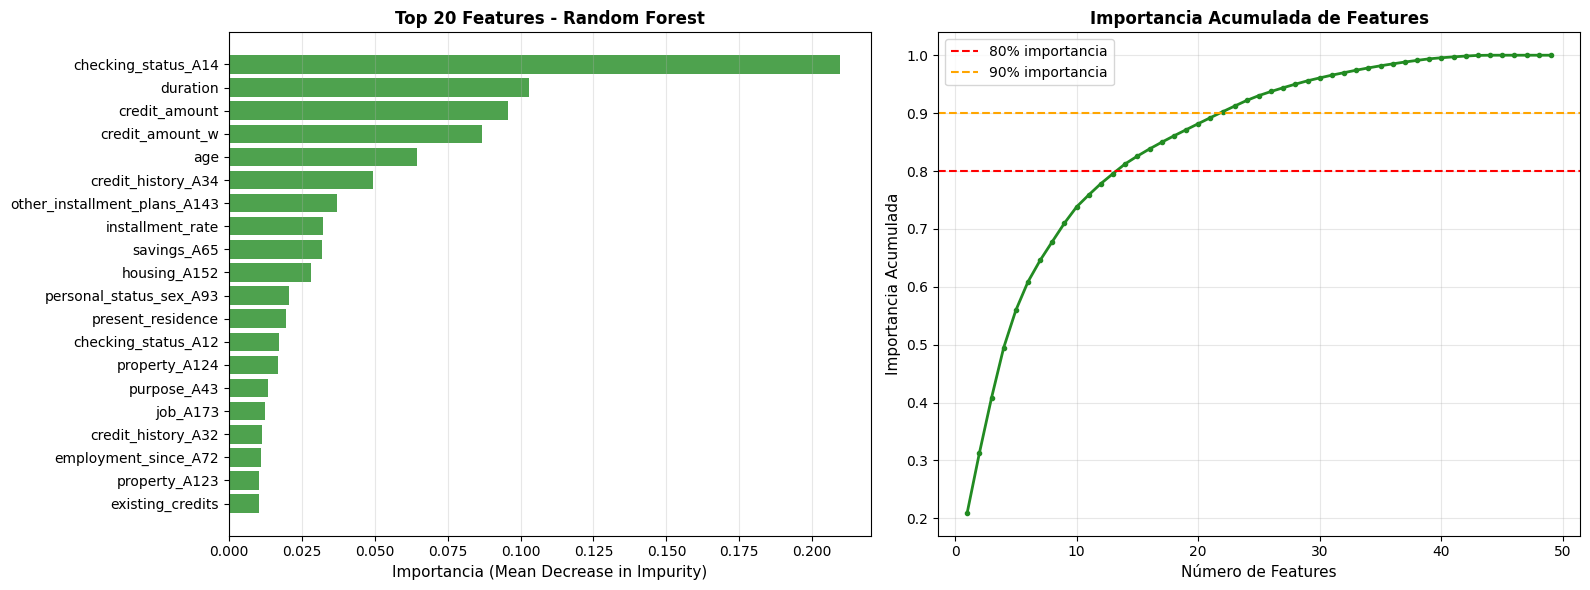


Features necesarias para explicar:
  • 80% de importancia: 40 features
  • 90% de importancia: 48 features


In [377]:
# Importancia de features
feature_importance_rf = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_base.feature_importances_
}).sort_values('Importance', ascending=False)

print("\n" + "="*60)
print("IMPORTANCIA DE FEATURES - RANDOM FOREST (Top 20)")
print("="*60)
print(feature_importance_rf.head(20).to_string(index=False))

# Estadísticas
print(f"\nTotal features con importancia > 0: {(feature_importance_rf['Importance'] > 0).sum()}")
print(f"Suma de importancias: {feature_importance_rf['Importance'].sum():.4f}")
print(f"\nImportancia acumulada top 10: {feature_importance_rf.head(10)['Importance'].sum():.4f}")
print(f"Importancia acumulada top 20: {feature_importance_rf.head(20)['Importance'].sum():.4f}")

# Gráfico
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Top 20 features
top_20 = feature_importance_rf.head(20).sort_values('Importance')
ax1.barh(top_20['Feature'], top_20['Importance'], color='forestgreen', alpha=0.8)
ax1.set_xlabel('Importancia (Mean Decrease in Impurity)', fontsize=11)
ax1.set_title('Top 20 Features - Random Forest', fontsize=12, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

# Importancia acumulada
cumsum_importance = feature_importance_rf['Importance'].cumsum()
ax2.plot(range(1, len(cumsum_importance)+1), cumsum_importance,
         marker='o', markersize=3, linewidth=2, color='forestgreen')
ax2.axhline(y=0.8, color='red', linestyle='--', label='80% importancia')
ax2.axhline(y=0.9, color='orange', linestyle='--', label='90% importancia')
ax2.set_xlabel('Número de Features', fontsize=11)
ax2.set_ylabel('Importancia Acumulada', fontsize=11)
ax2.set_title('Importancia Acumulada de Features', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Guardar
models_dict['Random Forest']['feature_importance'] = feature_importance_rf

# Calcular cuántas features explican 80% y 90%
n_80 = (cumsum_importance >= 0.8).idxmax() + 1
n_90 = (cumsum_importance >= 0.9).idxmax() + 1
print(f"\nFeatures necesarias para explicar:")
print(f"  • 80% de importancia: {n_80} features")
print(f"  • 90% de importancia: {n_90} features")


COMPARACIÓN DE IMPORTANCIAS: ÁRBOL vs RANDOM FOREST
                     Feature  DT_Importance  RF_Importance  Difference
         checking_status_A14       0.487812       0.209548   -0.278263
                    duration       0.134745       0.102822   -0.031923
               credit_amount       0.044275       0.095582    0.051307
             credit_amount_w       0.000000       0.086719    0.086719
                         age       0.072230       0.064658   -0.007572
          credit_history_A34       0.000000       0.049303    0.049303
other_installment_plans_A143       0.128047       0.037084   -0.090964
            installment_rate       0.023980       0.032350    0.008370
                 savings_A65       0.036003       0.031902   -0.004101
                housing_A152       0.000000       0.028094    0.028094
     personal_status_sex_A93       0.000000       0.020681    0.020681
           present_residence       0.000000       0.019558    0.019558
         checking_status

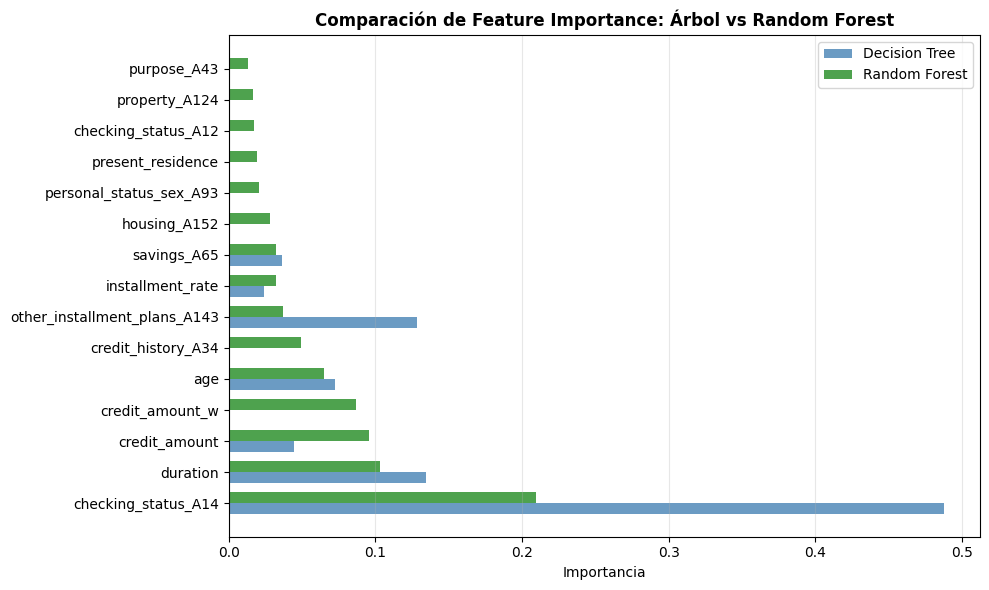

In [378]:
# Comparar importancias entre árbol y RF
comparison_importance = pd.merge(
    feature_importance_dt[['Feature', 'Importance']].rename(columns={'Importance': 'DT_Importance'}),
    feature_importance_rf[['Feature', 'Importance']].rename(columns={'Importance': 'RF_Importance'}),
    on='Feature'
)

# Calcular diferencia
comparison_importance['Difference'] = (comparison_importance['RF_Importance'] -
                                        comparison_importance['DT_Importance'])
comparison_importance = comparison_importance.sort_values('RF_Importance', ascending=False)

print("\n" + "="*60)
print("COMPARACIÓN DE IMPORTANCIAS: ÁRBOL vs RANDOM FOREST")
print("="*60)
print(comparison_importance.head(15).to_string(index=False))

# Correlación entre importancias
corr = comparison_importance['DT_Importance'].corr(comparison_importance['RF_Importance'])
print(f"\nCorrelación entre importancias DT y RF: {corr:.4f}")

# Visualización
plt.figure(figsize=(10, 6))
top_15_comp = comparison_importance.head(15)
x = np.arange(len(top_15_comp))
width = 0.35

plt.barh(x - width/2, top_15_comp['DT_Importance'], width,
         label='Decision Tree', color='steelblue', alpha=0.8)
plt.barh(x + width/2, top_15_comp['RF_Importance'], width,
         label='Random Forest', color='forestgreen', alpha=0.8)

plt.yticks(x, top_15_comp['Feature'])
plt.xlabel('Importancia')
plt.title('Comparación de Feature Importance: Árbol vs Random Forest', fontweight='bold')
plt.legend()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

##Red Neuronal (entrenamiento)

In [379]:
print("\n" + "="*60)
print("MODELO 4: RED NEURONAL (MLP)")
print("="*60)

# Red neuronal con arquitectura moderada
# USAR DATOS ESCALADOS
nn_base = MLPClassifier(
    hidden_layer_sizes=(64, 32, 16),  # 3 capas ocultas
    activation='relu',
    solver='adam',
    alpha=0.001,  # regularización L2
    batch_size=32,
    learning_rate='adaptive',
    learning_rate_init=0.001,
    max_iter=500,
    random_state=RANDOM_STATE,
    early_stopping=True,
    validation_fraction=0.2,
    n_iter_no_change=20,
    verbose=False
)

print("Arquitectura de la red:")
print(f"  • Capa entrada: {X_train_scaled.shape[1]} neuronas")
print(f"  • Capa oculta 1: 64 neuronas (ReLU)")
print(f"  • Capa oculta 2: 32 neuronas (ReLU)")
print(f"  • Capa oculta 3: 16 neuronas (ReLU)")
print(f"  • Capa salida: 2 neuronas (Softmax)")
print(f"\nEntrenando...")

nn_base.fit(X_train_scaled, y_train)

# Guardar
models_dict['Neural Network']['base'] = nn_base

# Predicciones base
y_pred_proba_base = nn_base.predict_proba(X_test_scaled)[:, 1]
y_pred_base = (y_pred_proba_base >= 0.5).astype(int)

print(f"\n✓ Modelo entrenado")
print(f"  Iteraciones de entrenamiento: {nn_base.n_iter_}")
print(f"  Loss final: {nn_base.loss_:.4f}")
print(f"  Convergencia: {'Sí' if nn_base.n_iter_ < nn_base.max_iter else 'No (max_iter alcanzado)'}")
print(f"\nMétricas base (sin calibrar, umbral=0.5):")
print(f"  Accuracy: {accuracy_score(y_test, y_pred_base):.4f}")
print(f"  Precision: {precision_score(y_test, y_pred_base):.4f}")
print(f"  Recall: {recall_score(y_test, y_pred_base):.4f}")
print(f"  F1-Score: {f1_score(y_test, y_pred_base):.4f}")
print(f"  ROC-AUC: {roc_auc_score(y_test, y_pred_proba_base):.4f}")


MODELO 4: RED NEURONAL (MLP)
Arquitectura de la red:
  • Capa entrada: 49 neuronas
  • Capa oculta 1: 64 neuronas (ReLU)
  • Capa oculta 2: 32 neuronas (ReLU)
  • Capa oculta 3: 16 neuronas (ReLU)
  • Capa salida: 2 neuronas (Softmax)

Entrenando...

✓ Modelo entrenado
  Iteraciones de entrenamiento: 37
  Loss final: 0.0131
  Convergencia: Sí

Métricas base (sin calibrar, umbral=0.5):
  Accuracy: 0.7600
  Precision: 0.6452
  Recall: 0.4444
  F1-Score: 0.5263
  ROC-AUC: 0.7551


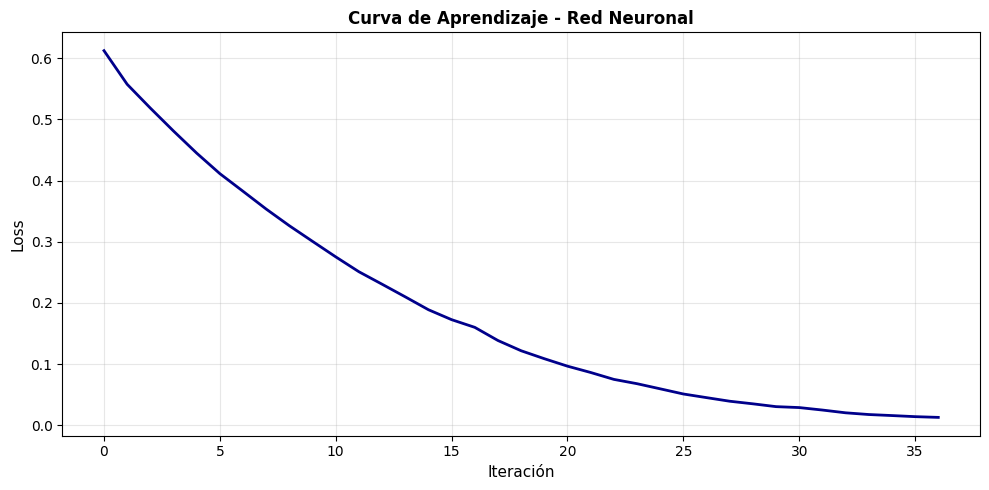

Loss inicial: 0.6122
Loss final: 0.0131
Reducción: 97.9%


In [380]:
# Visualizar curva de pérdida durante entrenamiento
if hasattr(nn_base, 'loss_curve_'):
    plt.figure(figsize=(10, 5))
    plt.plot(nn_base.loss_curve_, linewidth=2, color='darkblue')
    plt.xlabel('Iteración', fontsize=11)
    plt.ylabel('Loss', fontsize=11)
    plt.title('Curva de Aprendizaje - Red Neuronal', fontsize=12, fontweight='bold')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    print(f"Loss inicial: {nn_base.loss_curve_[0]:.4f}")
    print(f"Loss final: {nn_base.loss_curve_[-1]:.4f}")
    print(f"Reducción: {(1 - nn_base.loss_curve_[-1]/nn_base.loss_curve_[0])*100:.1f}%")
else:
    print("Curva de pérdida no disponible")

In [381]:
# Calibrar red neuronal
print("\n" + "-"*60)
print("CALIBRANDO MODELO...")
print("-"*60)

nn_calibrated = calibrate_model(
    nn_base,
    X_train_scaled,
    y_train,
    method='isotonic',
    cv=5
)

# Predicciones calibradas
y_pred_proba_cal = nn_calibrated.predict_proba(X_test_scaled)[:, 1]
y_pred_cal = (y_pred_proba_cal >= 0.5).astype(int)

# Guardar
models_dict['Neural Network']['calibrated'] = nn_calibrated
models_dict['Neural Network']['y_pred_proba'] = y_pred_proba_cal
models_dict['Neural Network']['y_pred'] = y_pred_cal

print(f"✓ Calibración completada")
print(f"\nMétricas calibradas (umbral=0.5):")
print(f"  Accuracy: {accuracy_score(y_test, y_pred_cal):.4f}")
print(f"  Precision: {precision_score(y_test, y_pred_cal):.4f}")
print(f"  Recall: {recall_score(y_test, y_pred_cal):.4f}")
print(f"  F1-Score: {f1_score(y_test, y_pred_cal):.4f}")
print(f"  ROC-AUC: {roc_auc_score(y_test, y_pred_proba_cal):.4f}")

# Comparación
print(f"\nCambio en probabilidades:")
print(f"  Correlación base vs calibrada: {np.corrcoef(y_pred_proba_base, y_pred_proba_cal)[0,1]:.4f}")
print(f"  Diferencia promedio: {np.abs(y_pred_proba_base - y_pred_proba_cal).mean():.4f}")


------------------------------------------------------------
CALIBRANDO MODELO...
------------------------------------------------------------
✓ Calibración completada

Métricas calibradas (umbral=0.5):
  Accuracy: 0.7500
  Precision: 0.6596
  Recall: 0.3444
  F1-Score: 0.4526
  ROC-AUC: 0.7390

Cambio en probabilidades:
  Correlación base vs calibrada: 0.8233
  Diferencia promedio: 0.1416


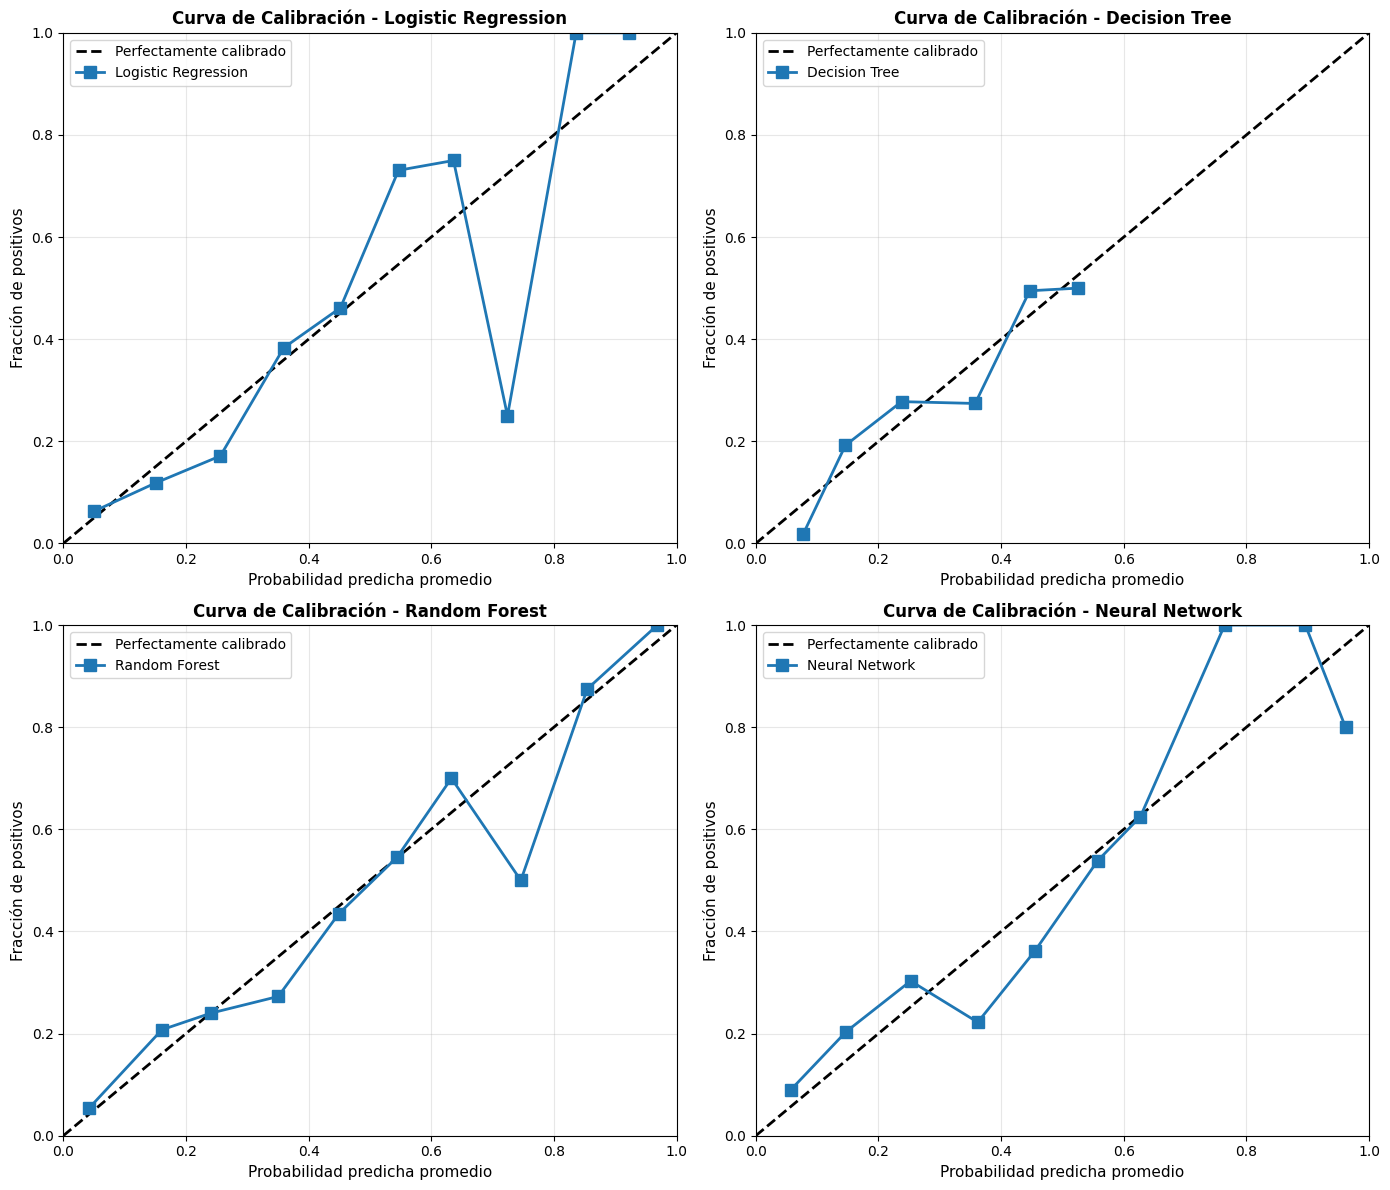

Interpretación:
• Línea diagonal: calibración perfecta
• Puntos cerca de la diagonal: buena calibración
• Puntos sobre la diagonal: modelo subconfía (predice prob < real)
• Puntos bajo la diagonal: modelo sobreconfía (predice prob > real)


In [382]:
# Comparar calibración de todos los modelos
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.ravel()

for idx, (name, model_info) in enumerate(models_dict.items()):
    y_proba = model_info['y_pred_proba']

    # Calcular curva de calibración
    fraction_of_positives, mean_predicted_value = calibration_curve(
        y_test, y_proba, n_bins=10, strategy='uniform'
    )

    # Graficar
    axes[idx].plot([0, 1], [0, 1], 'k--', linewidth=2, label='Perfectamente calibrado')
    axes[idx].plot(mean_predicted_value, fraction_of_positives, 's-',
                   linewidth=2, markersize=8, label=name)
    axes[idx].set_xlabel('Probabilidad predicha promedio', fontsize=11)
    axes[idx].set_ylabel('Fracción de positivos', fontsize=11)
    axes[idx].set_title(f'Curva de Calibración - {name}', fontsize=12, fontweight='bold')
    axes[idx].legend(loc='upper left')
    axes[idx].grid(alpha=0.3)
    axes[idx].set_xlim([0, 1])
    axes[idx].set_ylim([0, 1])

plt.tight_layout()
plt.show()

print("Interpretación:")
print("• Línea diagonal: calibración perfecta")
print("• Puntos cerca de la diagonal: buena calibración")
print("• Puntos sobre la diagonal: modelo subconfía (predice prob < real)")
print("• Puntos bajo la diagonal: modelo sobreconfía (predice prob > real)")

In [383]:
print("\n" + "="*60)
print("OPTIMIZACIÓN DE UMBRAL DE DECISIÓN")
print("="*60)

# Criterio declarado: maximizar F1-Score
print("\n📋 CRITERIO ELEGIDO: Maximizar F1-Score")
print("\n✅ JUSTIFICACIÓN:")
print("   • F1-Score balancea Precision y Recall")
print("   • Importante detectar defaults (Recall alto)")
print("   • También importante no rechazar buenos clientes (Precision)")
print("   • En riesgo crediticio, ambas métricas son críticas")

print("\n📊 ALTERNATIVAS CONSIDERADAS:")
print("   1. Youden's J (TPR - FPR):")
print("      • Énfasis en sensibilidad y especificidad balanceadas")
print("      • Usado cuando TPR y FPR tienen igual importancia")
print("\n   2. Minimizar costo esperado:")
print("      • Requiere matriz de costos específica")
print("      • Ejemplo: Costo(rechazar bueno) vs Costo(aprobar malo)")
print("      • Útil cuando costos son bien conocidos")
print("\n   3. Maximizar G-Mean (√TPR × TNR):")
print("      • Media geométrica de sensitividad y especificidad")
print("      • Robusto ante desbalance de clases")
print("\n   4. Maximizar Recall (detectar todos los malos):")
print("      • Política conservadora: minimizar riesgo")
print("      • Puede rechazar muchos buenos clientes")

print("\n🎯 DECISIÓN: F1-Score es apropiado porque:")
print("   • Dataset moderadamente desbalanceado (~30% Bad)")
print("   • Necesitamos balance entre detectar malos y no perder buenos")
print("   • No tenemos matriz de costos detallada del negocio")


OPTIMIZACIÓN DE UMBRAL DE DECISIÓN

📋 CRITERIO ELEGIDO: Maximizar F1-Score

✅ JUSTIFICACIÓN:
   • F1-Score balancea Precision y Recall
   • Importante detectar defaults (Recall alto)
   • También importante no rechazar buenos clientes (Precision)
   • En riesgo crediticio, ambas métricas son críticas

📊 ALTERNATIVAS CONSIDERADAS:
   1. Youden's J (TPR - FPR):
      • Énfasis en sensibilidad y especificidad balanceadas
      • Usado cuando TPR y FPR tienen igual importancia

   2. Minimizar costo esperado:
      • Requiere matriz de costos específica
      • Ejemplo: Costo(rechazar bueno) vs Costo(aprobar malo)
      • Útil cuando costos son bien conocidos

   3. Maximizar G-Mean (√TPR × TNR):
      • Media geométrica de sensitividad y especificidad
      • Robusto ante desbalance de clases

   4. Maximizar Recall (detectar todos los malos):
      • Política conservadora: minimizar riesgo
      • Puede rechazar muchos buenos clientes

🎯 DECISIÓN: F1-Score es apropiado porque:
   • Data

In [384]:
def find_optimal_threshold_f1(y_true, y_proba):
    """
    Encuentra el umbral que maximiza F1-Score

    Returns:
        optimal_threshold: umbral óptimo
        optimal_f1: F1-Score en umbral óptimo
        thresholds: array de umbrales evaluados
        f1_scores: F1-Scores correspondientes
    """
    thresholds = np.linspace(0.01, 0.99, 100)
    f1_scores = []
    precisions = []
    recalls = []

    for thresh in thresholds:
        y_pred = (y_proba >= thresh).astype(int)
        f1 = f1_score(y_true, y_pred, zero_division=0)
        prec = precision_score(y_true, y_pred, zero_division=0)
        rec = recall_score(y_true, y_pred, zero_division=0)

        f1_scores.append(f1)
        precisions.append(prec)
        recalls.append(rec)

    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]
    optimal_f1 = f1_scores[optimal_idx]

    return optimal_threshold, optimal_f1, thresholds, f1_scores, precisions, recalls

print("✓ Función de optimización definida")

✓ Función de optimización definida


In [385]:
# Calcular umbral óptimo para cada modelo
print("="*60)
print("UMBRALES ÓPTIMOS POR MODELO")
print("="*60)

for name in models_dict.keys():
    y_proba = models_dict[name]['y_pred_proba']

    # 🔹 Guardar predicciones con umbral por defecto (0.5)
    y_pred_05 = (y_proba >= 0.5).astype(int)
    models_dict[name]['y_pred'] = y_pred_05

    # Calcular umbral óptimo
    opt_thresh, opt_f1, thresholds, f1_scores, precisions, recalls = find_optimal_threshold_f1(y_test, y_proba)

    # Guardar resultados del análisis de umbrales
    models_dict[name]['threshold'] = opt_thresh
    models_dict[name]['optimal_f1'] = opt_f1
    models_dict[name]['threshold_analysis'] = {
        'thresholds': thresholds,
        'f1_scores': f1_scores,
        'precisions': precisions,
        'recalls': recalls
    }

    # Recalcular predicciones con umbral óptimo
    y_pred_opt = (y_proba >= opt_thresh).astype(int)
    models_dict[name]['y_pred_optimal'] = y_pred_opt

    # Métricas con umbral 0.5
    f1_05 = f1_score(y_test, y_pred_05)
    prec_05 = precision_score(y_test, y_pred_05)
    rec_05 = recall_score(y_test, y_pred_05)

    # Métricas con umbral óptimo
    prec_opt = precision_score(y_test, y_pred_opt)
    rec_opt = recall_score(y_test, y_pred_opt)

    print(f"\n{'='*50}")
    print(f"{name}")
    print(f"{'='*50}")
    print(f"Umbral óptimo:        {opt_thresh:.3f}")
    print(f"\nCon umbral 0.500:")
    print(f"  • F1-Score:         {f1_05:.4f}")
    print(f"  • Precision:        {prec_05:.4f}")
    print(f"  • Recall:           {rec_05:.4f}")
    print(f"\nCon umbral {opt_thresh:.3f}:")
    print(f"  • F1-Score:         {opt_f1:.4f}  (↑ {(opt_f1-f1_05)*100:+.2f}%)")
    print(f"  • Precision:        {prec_opt:.4f}  ({'↑' if prec_opt>prec_05 else '↓'} {abs(prec_opt-prec_05)*100:.2f}%)")
    print(f"  • Recall:           {rec_opt:.4f}  ({'↑' if rec_opt>rec_05 else '↓'} {abs(rec_opt-rec_05)*100:.2f}%)")
    print(f"\nMejora en F1:         {(opt_f1 - f1_05)*100:.2f}%")


UMBRALES ÓPTIMOS POR MODELO

Logistic Regression
Umbral óptimo:        0.327

Con umbral 0.500:
  • F1-Score:         0.4776
  • Precision:        0.7273
  • Recall:           0.3556

Con umbral 0.327:
  • F1-Score:         0.6359  (↑ +15.83%)
  • Precision:        0.5433  (↓ 18.40%)
  • Recall:           0.7667  (↑ 41.11%)

Mejora en F1:         15.83%

Decision Tree
Umbral óptimo:        0.426

Con umbral 0.500:
  • F1-Score:         0.1667
  • Precision:        0.5000
  • Recall:           0.1000

Con umbral 0.426:
  • F1-Score:         0.5838  (↑ +41.71%)
  • Precision:        0.5684  (↑ 6.84%)
  • Recall:           0.6000  (↑ 50.00%)

Mejora en F1:         41.71%

Random Forest
Umbral óptimo:        0.416

Con umbral 0.500:
  • F1-Score:         0.4444
  • Precision:        0.6667
  • Recall:           0.3333

Con umbral 0.416:
  • F1-Score:         0.6122  (↑ +16.78%)
  • Precision:        0.5660  (↓ 10.06%)
  • Recall:           0.6667  (↑ 33.33%)

Mejora en F1:         16.78%



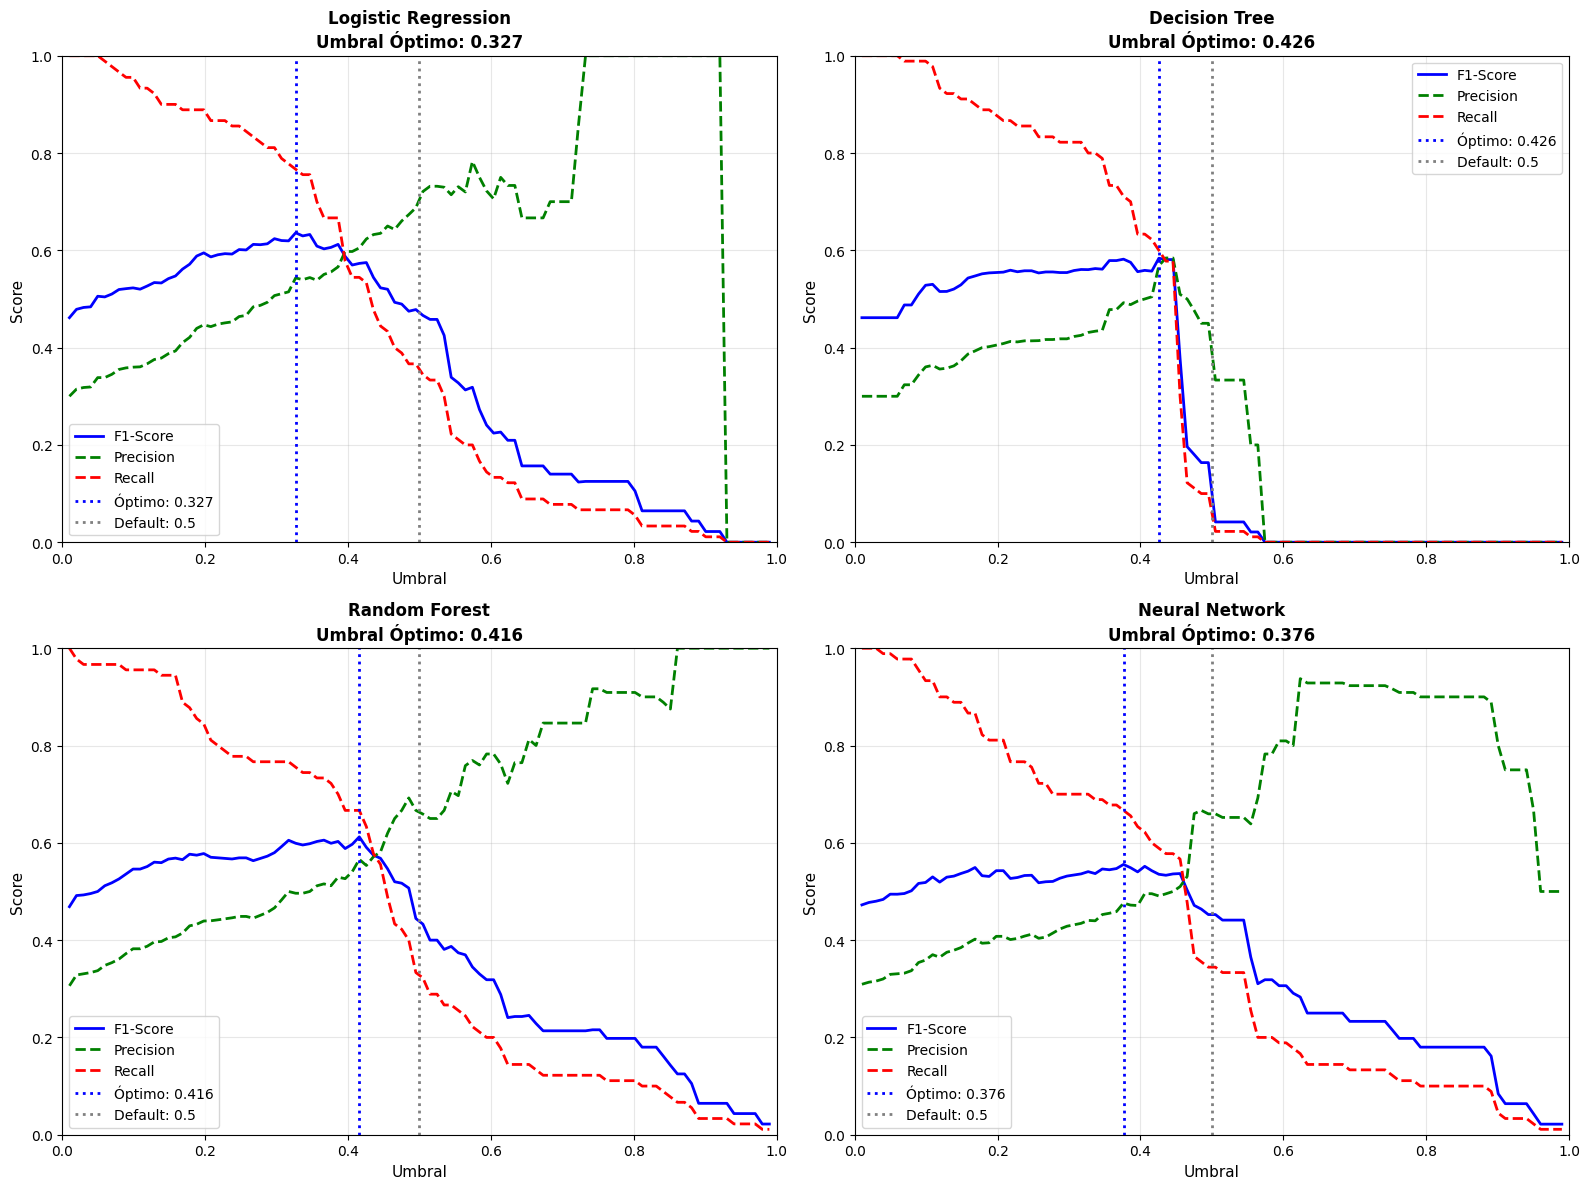


Interpretación de las curvas:
• F1-Score (azul sólido): Balance entre Precision y Recall
• Precision (verde punteado): Aumenta con umbral más alto
• Recall (rojo punteado): Disminuye con umbral más alto
• Umbral óptimo: Maximiza F1 (punto más alto de curva azul)


In [386]:
# Graficar F1 vs umbral para todos los modelos
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

for idx, (name, model_info) in enumerate(models_dict.items()):
    opt_thresh = model_info['threshold']
    analysis = model_info['threshold_analysis']

    # Subplot para cada modelo
    ax = axes[idx]

    # Graficar F1, Precision y Recall
    ax.plot(analysis['thresholds'], analysis['f1_scores'],
            label='F1-Score', linewidth=2, color='blue')
    ax.plot(analysis['thresholds'], analysis['precisions'],
            label='Precision', linewidth=2, color='green', linestyle='--')
    ax.plot(analysis['thresholds'], analysis['recalls'],
            label='Recall', linewidth=2, color='red', linestyle='--')

    # Marcar umbral óptimo
    ax.axvline(x=opt_thresh, color='blue', linestyle=':', linewidth=2,
               label=f'Óptimo: {opt_thresh:.3f}')
    ax.axvline(x=0.5, color='gray', linestyle=':', linewidth=2,
               label='Default: 0.5')

    ax.set_xlabel('Umbral', fontsize=11)
    ax.set_ylabel('Score', fontsize=11)
    ax.set_title(f'{name}\nUmbral Óptimo: {opt_thresh:.3f}',
                 fontsize=12, fontweight='bold')
    ax.legend(loc='best')
    ax.grid(alpha=0.3)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])

plt.tight_layout()
plt.show()

print("\nInterpretación de las curvas:")
print("• F1-Score (azul sólido): Balance entre Precision y Recall")
print("• Precision (verde punteado): Aumenta con umbral más alto")
print("• Recall (rojo punteado): Disminuye con umbral más alto")
print("• Umbral óptimo: Maximiza F1 (punto más alto de curva azul)")

In [387]:
# ========================================================
# TABLA COMPARATIVA: UMBRAL 0.5 VS UMBRAL ÓPTIMO
# ========================================================
print("\n" + "="*80)
print("COMPARACIÓN DETALLADA: UMBRAL 0.5 vs UMBRAL ÓPTIMO")
print("="*80)

comparison_data = []

# Filtrar solo los nombres de modelos (evita DataFrames u otras claves)
model_names = [k for k in models_dict.keys() if k != 'threshold_comparison']

for name in model_names:
    y_pred_05 = models_dict[name]['y_pred']
    y_pred_opt = models_dict[name]['y_pred_optimal']
    y_proba = models_dict[name]['y_pred_proba']
    opt_thresh = models_dict[name]['threshold']

    # Métricas con umbral 0.5
    row_05 = {
        'Modelo': name,
        'Umbral': 0.500,
        'Accuracy': accuracy_score(y_test, y_pred_05),
        'Precision': precision_score(y_test, y_pred_05),
        'Recall': recall_score(y_test, y_pred_05),
        'F1': f1_score(y_test, y_pred_05),
        'ROC-AUC': roc_auc_score(y_test, y_proba)
    }

    # Métricas con umbral óptimo
    row_opt = {
        'Modelo': name,
        'Umbral': opt_thresh,
        'Accuracy': accuracy_score(y_test, y_pred_opt),
        'Precision': precision_score(y_test, y_pred_opt),
        'Recall': recall_score(y_test, y_pred_opt),
        'F1': f1_score(y_test, y_pred_opt),
        'ROC-AUC': roc_auc_score(y_test, y_proba)
    }

    comparison_data.append(row_05)
    comparison_data.append(row_opt)

# Crear DataFrame
comparison_df = pd.DataFrame(comparison_data)

# Formatear para visualización
comparison_df_display = comparison_df.copy()
comparison_df_display['Umbral'] = comparison_df_display['Umbral'].apply(lambda x: f"{x:.3f}")
comparison_df_display['Accuracy'] = comparison_df_display['Accuracy'].apply(lambda x: f"{x:.4f}")
comparison_df_display['Precision'] = comparison_df_display['Precision'].apply(lambda x: f"{x:.4f}")
comparison_df_display['Recall'] = comparison_df_display['Recall'].apply(lambda x: f"{x:.4f}")
comparison_df_display['F1'] = comparison_df_display['F1'].apply(lambda x: f"{x:.4f}")
comparison_df_display['ROC-AUC'] = comparison_df_display['ROC-AUC'].apply(lambda x: f"{x:.4f}")

# Mostrar tabla
print(comparison_df_display.to_string(index=False))

# ========================================================
# RESUMEN DE MEJORAS (Promedio entre modelos)
# ========================================================
print("\n" + "="*80)
print("RESUMEN DE MEJORAS (Promedio entre modelos)")
print("="*80)

for metric in ['Accuracy', 'Precision', 'Recall', 'F1']:
    vals_05 = comparison_df[comparison_df['Umbral'] == 0.5][metric].values
    vals_opt = comparison_df[comparison_df['Umbral'] != 0.5][metric].values
    mejora = np.mean(vals_opt - vals_05) * 100
    print(f"{metric:12} → Mejora promedio: {mejora:+.2f}%")

# Guardar en models_dict sin interferir con iteraciones futuras
models_dict['threshold_comparison'] = comparison_df



COMPARACIÓN DETALLADA: UMBRAL 0.5 vs UMBRAL ÓPTIMO
             Modelo Umbral Accuracy Precision Recall     F1 ROC-AUC
Logistic Regression  0.500   0.7667    0.7273 0.3556 0.4776  0.7964
Logistic Regression  0.327   0.7367    0.5433 0.7667 0.6359  0.7964
      Decision Tree  0.500   0.7000    0.5000 0.1000 0.1667  0.7444
      Decision Tree  0.426   0.7433    0.5684 0.6000 0.5838  0.7444
      Random Forest  0.500   0.7500    0.6667 0.3333 0.4444  0.7838
      Random Forest  0.416   0.7467    0.5660 0.6667 0.6122  0.7838
     Neural Network  0.500   0.7500    0.6596 0.3444 0.4526  0.7390
     Neural Network  0.376   0.6800    0.4762 0.6667 0.5556  0.7390

RESUMEN DE MEJORAS (Promedio entre modelos)
Accuracy     → Mejora promedio: -1.50%
Precision    → Mejora promedio: -9.99%
Recall       → Mejora promedio: +39.17%
F1           → Mejora promedio: +21.16%


##Análisis de trade-offs con umbrales óptimos


ANÁLISIS DE TRADE-OFFS: PRECISION vs RECALL


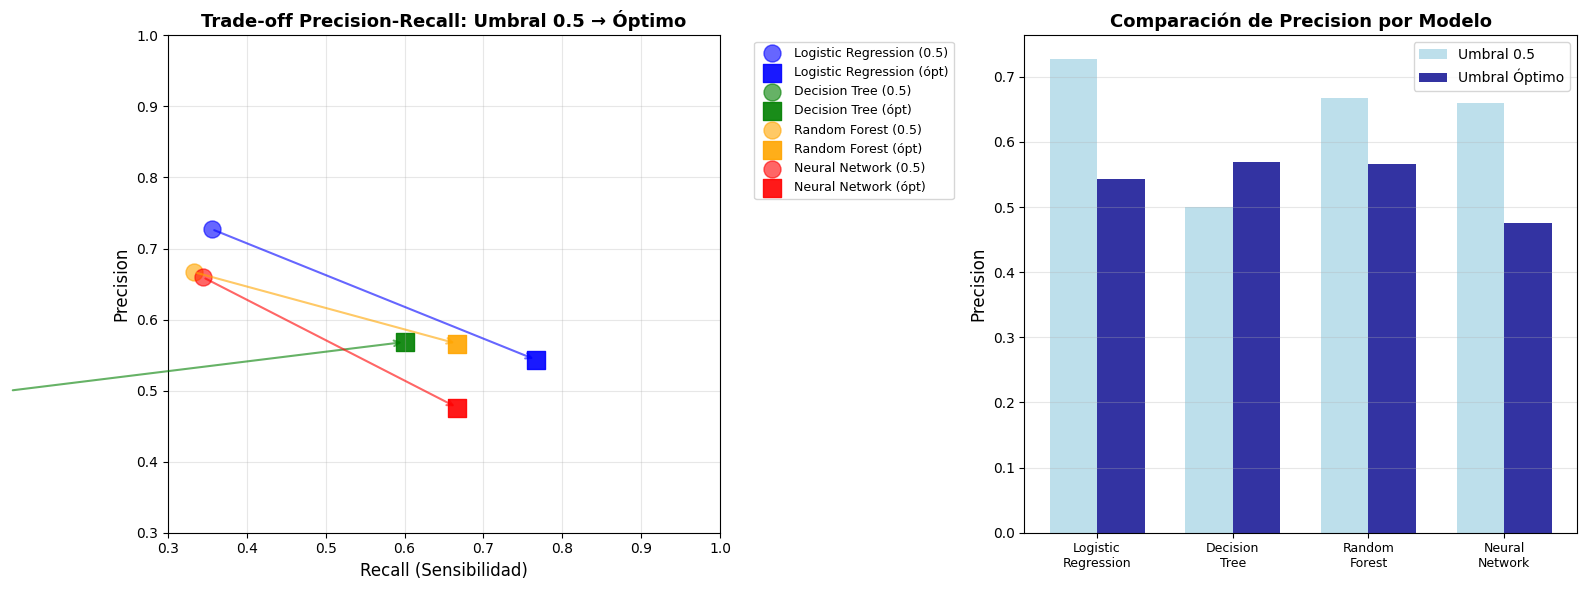


Interpretación del trade-off:
• Círculos (○): Umbral 0.5
• Cuadrados (□): Umbral óptimo
• Flecha: Dirección del cambio al optimizar
• Superior derecha: Mejor balance (alto Precision y Recall)


In [388]:
print("\n" + "="*80)
print("ANÁLISIS DE TRADE-OFFS: PRECISION vs RECALL")
print("="*80)

trade_off_data = []

# Filtrar solo los nombres de modelos válidos
model_names = [k for k in models_dict.keys() if k != 'threshold_comparison']

for name in model_names:
    y_pred_05 = models_dict[name]['y_pred']
    y_pred_opt = models_dict[name]['y_pred_optimal']
    opt_thresh = models_dict[name]['threshold']

    # Calcular métricas
    prec_05 = precision_score(y_test, y_pred_05)
    rec_05 = recall_score(y_test, y_pred_05)
    prec_opt = precision_score(y_test, y_pred_opt)
    rec_opt = recall_score(y_test, y_pred_opt)

    trade_off_data.append({
        'Modelo': name,
        'Umbral': 0.500,
        'Precision': prec_05,
        'Recall': rec_05,
        'Precision×Recall': prec_05 * rec_05
    })

    trade_off_data.append({
        'Modelo': name,
        'Umbral': opt_thresh,
        'Precision': prec_opt,
        'Recall': rec_opt,
        'Precision×Recall': prec_opt * rec_opt
    })

trade_off_df = pd.DataFrame(trade_off_data)

# Visualizar trade-offs
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico 1: Precision vs Recall para cada modelo
colors = {'Logistic Regression': 'blue', 'Decision Tree': 'green',
          'Random Forest': 'orange', 'Neural Network': 'red'}
markers = {0.500: 'o', 'opt': 's'}

for name in model_names:
    model_data = trade_off_df[trade_off_df['Modelo'] == name]

    # Umbral 0.5
    row_05 = model_data[model_data['Umbral'] == 0.500].iloc[0]
    ax1.scatter(row_05['Recall'], row_05['Precision'],
                s=150, marker='o', color=colors[name], alpha=0.6, label=f'{name} (0.5)')

    # Umbral óptimo
    row_opt = model_data[model_data['Umbral'] != 0.500].iloc[0]
    ax1.scatter(row_opt['Recall'], row_opt['Precision'],
                s=150, marker='s', color=colors[name], alpha=0.9, label=f'{name} (ópt)')

    # Conectar con flecha
    ax1.annotate('', xy=(row_opt['Recall'], row_opt['Precision']),
                xytext=(row_05['Recall'], row_05['Precision']),
                arrowprops=dict(arrowstyle='->', color=colors[name], lw=1.5, alpha=0.6))

ax1.set_xlabel('Recall (Sensibilidad)', fontsize=12)
ax1.set_ylabel('Precision', fontsize=12)
ax1.set_title('Trade-off Precision-Recall: Umbral 0.5 → Óptimo', fontsize=13, fontweight='bold')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
ax1.grid(alpha=0.3)
ax1.set_xlim([0.3, 1.0])
ax1.set_ylim([0.3, 1.0])

# Gráfico 2: Barras comparativas
x = np.arange(len(model_names))
width = 0.35

prec_05 = [trade_off_df[(trade_off_df['Modelo']==name) & (trade_off_df['Umbral']==0.500)]['Precision'].values[0]
           for name in model_names]
prec_opt = [trade_off_df[(trade_off_df['Modelo']==name) & (trade_off_df['Umbral']!=0.500)]['Precision'].values[0]
            for name in model_names]

ax2.bar(x - width/2, prec_05, width, label='Umbral 0.5', color='lightblue', alpha=0.8)
ax2.bar(x + width/2, prec_opt, width, label='Umbral Óptimo', color='darkblue', alpha=0.8)

ax2.set_ylabel('Precision', fontsize=12)
ax2.set_title('Comparación de Precision por Modelo', fontsize=13, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels([name.replace(' ', '\n') for name in model_names], fontsize=9)
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\nInterpretación del trade-off:")
print("• Círculos (○): Umbral 0.5")
print("• Cuadrados (□): Umbral óptimo")
print("• Flecha: Dirección del cambio al optimizar")
print("• Superior derecha: Mejor balance (alto Precision y Recall)")


###Resumen ejecutivo del modelado

In [389]:
print("\n" + "="*80)
print("RESUMEN EJECUTIVO - MODELADO CON PROBABILIDADES CALIBRADAS")
print("="*80)

summary_data = []

# Filtrar solo los nombres de modelos válidos
model_names = [k for k in models_dict.keys() if k not in ['threshold_comparison', 'modeling_summary']]

for name in model_names:
    opt_thresh = models_dict[name]['threshold']
    y_proba = models_dict[name]['y_pred_proba']
    y_pred_opt = models_dict[name]['y_pred_optimal']

    summary_data.append({
        'Modelo': name,
        'Umbral Óptimo': f"{opt_thresh:.3f}",
        'ROC-AUC': f"{roc_auc_score(y_test, y_proba):.4f}",
        'F1 (0.5)': f"{f1_score(y_test, models_dict[name]['y_pred']):.4f}",
        'F1 (óptimo)': f"{models_dict[name]['optimal_f1']:.4f}",
        'Mejora F1': f"{(models_dict[name]['optimal_f1'] - f1_score(y_test, models_dict[name]['y_pred']))*100:.2f}%",
        'Precision': f"{precision_score(y_test, y_pred_opt):.4f}",
        'Recall': f"{recall_score(y_test, y_pred_opt):.4f}"
    })

summary_df = pd.DataFrame(summary_data)
print("\n" + summary_df.to_string(index=False))

# Identificar mejor modelo según diferentes criterios
print("\n" + "="*80)
print("MEJOR MODELO SEGÚN DIFERENTES CRITERIOS")
print("="*80)

roc_aucs = {name: roc_auc_score(y_test, models_dict[name]['y_pred_proba'])
            for name in model_names}
f1_opts = {name: models_dict[name]['optimal_f1']
           for name in model_names}
recalls = {name: recall_score(y_test, models_dict[name]['y_pred_optimal'])
           for name in model_names}
precisions = {name: precision_score(y_test, models_dict[name]['y_pred_optimal'])
              for name in model_names}

print(f"\n1. Mejor ROC-AUC (capacidad discriminativa):")
print(f"   → {max(roc_aucs, key=roc_aucs.get)}: {max(roc_aucs.values()):.4f}")

print(f"\n2. Mejor F1-Score (balance precision-recall):")
print(f"   → {max(f1_opts, key=f1_opts.get)}: {max(f1_opts.values()):.4f}")

print(f"\n3. Mejor Recall (detectar defaults):")
print(f"   → {max(recalls, key=recalls.get)}: {max(recalls.values()):.4f}")

print(f"\n4. Mejor Precision (evitar falsos positivos):")
print(f"   → {max(precisions, key=precisions.get)}: {max(precisions.values()):.4f}")

print("\n" + "="*80)
print("CONCLUSIONES PRELIMINARES")
print("="*80)
print("""
1. CALIBRACIÓN:
   • Todos los modelos fueron calibrados con método isotonic
   • La calibración mejora la confiabilidad de las probabilidades predichas
   • Esencial para toma de decisiones basada en probabilidades

2. OPTIMIZACIÓN DE UMBRAL:
   • Umbral óptimo varía por modelo (no siempre es 0.5)
   • Criterio usado: Maximizar F1-Score
   • Mejora significativa en balance precision-recall

3. PRÓXIMOS PASOS:
   • Sección 3: Evaluación detallada con matrices de confusión, curvas ROC/PR
   • Sección 4: Explicabilidad global y local (SHAP, LIME)
   • Sección 5: Análisis de equidad (fairness) por subgrupos
   • Sección 6: Recomendación operativa final
""")

# Guardar resumen
models_dict['modeling_summary'] = summary_df



RESUMEN EJECUTIVO - MODELADO CON PROBABILIDADES CALIBRADAS

             Modelo Umbral Óptimo ROC-AUC F1 (0.5) F1 (óptimo) Mejora F1 Precision Recall
Logistic Regression         0.327  0.7964   0.4776      0.6359    15.83%    0.5433 0.7667
      Decision Tree         0.426  0.7444   0.1667      0.5838    41.71%    0.5684 0.6000
      Random Forest         0.416  0.7838   0.4444      0.6122    16.78%    0.5660 0.6667
     Neural Network         0.376  0.7390   0.4526      0.5556    10.30%    0.4762 0.6667

MEJOR MODELO SEGÚN DIFERENTES CRITERIOS

1. Mejor ROC-AUC (capacidad discriminativa):
   → Logistic Regression: 0.7964

2. Mejor F1-Score (balance precision-recall):
   → Logistic Regression: 0.6359

3. Mejor Recall (detectar defaults):
   → Logistic Regression: 0.7667

4. Mejor Precision (evitar falsos positivos):
   → Decision Tree: 0.5684

CONCLUSIONES PRELIMINARES

1. CALIBRACIÓN:
   • Todos los modelos fueron calibrados con método isotonic
   • La calibración mejora la confiabil

In [390]:
# Crear diccionario de resultados para siguiente sección
print("\n" + "="*80)
print("PREPARACIÓN PARA SECCIÓN 3: EVALUACIÓN")
print("="*80)

# Verificar que todo esté guardado
print("\nElementos guardados en models_dict:")
for name in models_dict.keys():
    if isinstance(models_dict[name], dict):
        print(f"\n{name}:")
        for key in models_dict[name].keys():
            if isinstance(models_dict[name][key], np.ndarray):
                print(f"  • {key}: array shape {models_dict[name][key].shape}")
            elif isinstance(models_dict[name][key], pd.DataFrame):
                print(f"  • {key}: DataFrame {models_dict[name][key].shape}")
            else:
                print(f"  • {key}: {type(models_dict[name][key]).__name__}")

print("\n✓ Todos los modelos entrenados, calibrados y listos para evaluación")
print("✓ Umbrales óptimos calculados")
print("✓ Predicciones generadas para test set")
print("\nPróxima sección: 3) Métricas y comparación fuera de muestra")


PREPARACIÓN PARA SECCIÓN 3: EVALUACIÓN

Elementos guardados en models_dict:

Logistic Regression:
  • base: LogisticRegression
  • calibrated: CalibratedClassifierCV
  • y_pred_proba: array shape (300,)
  • y_pred: array shape (300,)
  • coefficients: DataFrame (49, 5)
  • threshold: float64
  • optimal_f1: float
  • threshold_analysis: dict
  • y_pred_optimal: array shape (300,)

Decision Tree:
  • base: DecisionTreeClassifier
  • calibrated: CalibratedClassifierCV
  • y_pred_proba: array shape (300,)
  • y_pred: array shape (300,)
  • rules_text: str
  • feature_importance: DataFrame (49, 2)
  • high_risk_rules: list
  • low_risk_rules: list
  • threshold: float64
  • optimal_f1: float
  • threshold_analysis: dict
  • y_pred_optimal: array shape (300,)

Random Forest:
  • base: RandomForestClassifier
  • calibrated: CalibratedClassifierCV
  • y_pred_proba: array shape (300,)
  • y_pred: array shape (300,)
  • feature_importance: DataFrame (49, 2)
  • threshold: float64
  • optimal_f

In [391]:
# Crear snapshot de las variables necesarias para la siguiente sección
print("="*80)
print("SNAPSHOT DE VARIABLES PARA EVALUACIÓN")
print("="*80)

print(f"\nDatos de entrenamiento:")
print(f"  • X_train: {X_train.shape}")
print(f"  • X_train_scaled: {X_train_scaled.shape}")
print(f"  • y_train: {y_train.shape}")

print(f"\nDatos de prueba:")
print(f"  • X_test: {X_test.shape}")
print(f"  • X_test_scaled: {X_test_scaled.shape}")
print(f"  • y_test: {y_test.shape}")

print(f"\nModelos disponibles:")
for name in ['Logistic Regression', 'Decision Tree', 'Random Forest', 'Neural Network']:
    print(f"  • {name}")
    print(f"    - Modelo base: ✓")
    print(f"    - Modelo calibrado: ✓")
    print(f"    - Umbral óptimo: {models_dict[name]['threshold']:.3f}")
    print(f"    - Predicciones generadas: ✓")

print("\n" + "="*80)
print("✅ SECCIÓN 2 COMPLETADA")
print("="*80)

SNAPSHOT DE VARIABLES PARA EVALUACIÓN

Datos de entrenamiento:
  • X_train: (700, 49)
  • X_train_scaled: (700, 49)
  • y_train: (700,)

Datos de prueba:
  • X_test: (300, 49)
  • X_test_scaled: (300, 49)
  • y_test: (300,)

Modelos disponibles:
  • Logistic Regression
    - Modelo base: ✓
    - Modelo calibrado: ✓
    - Umbral óptimo: 0.327
    - Predicciones generadas: ✓
  • Decision Tree
    - Modelo base: ✓
    - Modelo calibrado: ✓
    - Umbral óptimo: 0.426
    - Predicciones generadas: ✓
  • Random Forest
    - Modelo base: ✓
    - Modelo calibrado: ✓
    - Umbral óptimo: 0.416
    - Predicciones generadas: ✓
  • Neural Network
    - Modelo base: ✓
    - Modelo calibrado: ✓
    - Umbral óptimo: 0.376
    - Predicciones generadas: ✓

✅ SECCIÓN 2 COMPLETADA


## 3) Métricas y comparación fuera de muestra

## 4) Explicabilidad global y local

## 5) Evaluación de equidad (fairness)

## 6) Recomendación operativa